## Experiment 9

- Description : Essayer avec des masques grille vs masque convexes
- Motivation  : 

In [1]:
import os 
os.chdir('../../')

In [2]:
# -*- coding: utf-8 -*-
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import time
import importlib
import os
import argparse
import copy
import datetime
import random
import sys
import json

import torch
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
from torchvision import models
import torch.multiprocessing as mp
from torchvision import transforms

# My libs
from core.utils import Stack, ToTorchFormatTensor
import xarray as xr

from ssh_scripts.plot_maps import plot
from cartopy import crs as ccrs

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
plt.rcParams ['figure.figsize']  = 25, 10
plt.rcParams ['axes.labelsize']  = 14
plt.rcParams ['xtick.labelsize'] = 12
plt.rcParams ['ytick.labelsize'] = 12
plt.rcParams ['text.color']      = 'black'
plt.rcParams ['axes.labelcolor'] = 'black'
plt.rcParams ['xtick.color']     = 'black'
plt.rcParams ['ytick.color']     = 'black'
# plt.style.use('fivethirtyeight')


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [7]:
experiment = 9
path = f'Experiments/Experiment{experiment}/'
video = path + 'examples/'
mask = path + 'grid_masks/'
ckpt = 'checkpoints/sttn.pth'
model = 'sttn'

In [8]:
ensure_dir(mask)

### Create grid masks

In [49]:
w, h = 192, 192

grid_mask = np.zeros((w,h))+255
width = 1
step = 2
fill = False
counter = 0
for x in range(w):
    if counter==width:
        fill = False
    if counter ==step*width:
        fill = True
        counter=0
    if fill : 
        grid_mask[:,x]=0
        grid_mask[x,:]=0
    counter+=1

In [50]:
total_coverage = (width/step)*2
print(f'total_coverage : {np.round(100*total_coverage,2)} %')

total_coverage : 100.0 %


In [51]:
true_coverage = 1-((grid_mask==255).sum()/(grid_mask.shape[0]*grid_mask.shape[1]))
print(f'Actual coverage : {np.round(100*true_coverage,2)} %')


Actual coverage : 74.48 %


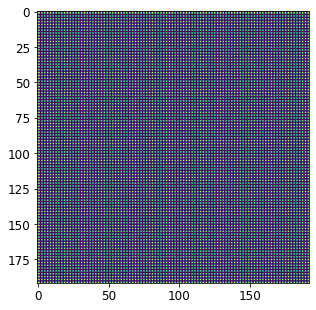

In [52]:
plt.figure(figsize=(5,5))
plt.imshow(grid_mask)

In [53]:
# save masks
for i in range(360):
    cv2.imwrite(f'{mask}/mask_{i}.png',grid_mask)

In [54]:
w, h = 192, 192
# w, h = 432, 240
ref_length = 10
neighbor_stride = 5
default_fps = 24

_to_tensors = transforms.Compose([
    Stack(),
    ToTorchFormatTensor()])


# sample reference frames from the whole video 
def get_ref_index(neighbor_ids, length):
    ref_index = []
    for i in range(0, length, ref_length):
        if not i in neighbor_ids:
            ref_index.append(i)
    return ref_index


# read frame-wise masks 
def read_mask(mpath):
    masks = []
    mnames = os.listdir(mpath)
    mnames.sort()
    for m in mnames: 
        if 'ipynb' not in m:
            m = Image.open(os.path.join(mpath, m))
#             m = m.resize((w, h), Image.NEAREST)
            m = np.array(m.convert('L'))
            m = np.array(m > 0).astype(np.uint8)
#             m = cv2.dilate(m, cv2.getStructuringElement(
#                 cv2.MORPH_CROSS, (3, 3)), iterations=4)
            masks.append(Image.fromarray(m*255))
    return masks


#  read frames from video 
def read_frame_from_videos(vname):
    frames = []
    vidcap = cv2.VideoCapture(vname)
    success, image = vidcap.read()
    count = 0
    while success:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        frames.append(image.resize((w,h)))
        success, image = vidcap.read()
        count += 1
    return frames       
#New
def get_ssh_gt():
    dataset_path = '../datasets/'
    ref_path = dataset_path + 'ref.nc'
    xgt = xr.open_dataset(ref_path)
    gt = xgt['ssh'].values
    gt = gt[:,5:197,5:197]
    
    maxx = gt.max()
    minn = gt.min()
    transformed_ssh = (gt-minn)/(maxx-minn) # à revoir
    # transformed_ssh =  transformed_ssh[..., np.newaxis]
    transformed_ssh = np.stack((transformed_ssh,)*3, axis=1)

    # ssh_frames = [Image.fromarray(cv2.cvtColor(transformed_ssh[i], cv2.COLOR_BGR2RGB)) for i in range(len(transformed_ssh))]
    
    return gt, torch.tensor(transformed_ssh), [transformed_ssh[i].transpose(1,2,0)*255 for i in range(len(transformed_ssh))],(maxx,minn), gt

def get_ssh_masks():
    pass


In [55]:
# set up models 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = importlib.import_module('model.' + model)
model = net.InpaintGenerator().to(device)
model_path = ckpt
data = torch.load(ckpt, map_location=device)
model.load_state_dict(data['netG'])
print('loading from: {}'.format(ckpt))
model.eval()

loading from: checkpoints/sttn.pth


InpaintGenerator(
  (transformer): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadedAttention(
        (query_embedding): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (value_embedding): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (key_embedding): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (output_linear): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (attention): Attention()
      )
      (feed_forward): FeedForward(
        (conv): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
    )
    (1): TransformerBlock(
     

In [56]:
gt, feats, frames, maxmin, gt = get_ssh_gt()
print('frames shape :', frames[0].shape)
feats = feats.unsqueeze(0)*2-1

frames shape : (192, 192, 3)


In [57]:
masks = read_mask(mask)


len_video = min(len(masks),len(frames))
frames = frames[:len_video]
masks  = masks[:len_video]
gt     = gt[:len_video] 
feats  = feats[:,:len_video]
video_length = len(frames)

frames = [np.array(f).astype(np.uint8) for f in frames]

binary_masks = [np.expand_dims((np.array(m) != 0).astype(np.uint8), 2) for m in masks]
masks = _to_tensors(masks).unsqueeze(0)
feats, masks = feats.to(device, dtype=torch.float), masks.to(device, dtype=torch.float)
comp_frames = [None]*video_length
comp_frames_ssh = [None]*video_length

In [58]:
## Encoding 365 frames into 365 vectors of 256 channels and 48x48 size

In [59]:
with torch.no_grad():
    feats = model.encoder((feats*(1-masks).float()).view(video_length, 3, h, w))
    _, c, feat_h, feat_w = feats.size()
    feats = feats.view(1, video_length, c, feat_h, feat_w)

In [60]:
print('loading videos and masks from: {}'.format(video))
print('feats output :',feats.shape)

loading videos and masks from: Experiments/Experiment9/examples/
feats output : torch.Size([1, 360, 256, 48, 48])


In [61]:
gt_reshaped = gt[:,:,:,np.newaxis]
maxx, minn = maxmin

In [62]:
for f in range(0, video_length, neighbor_stride):
    neighbor_ids = [i for i in range(max(0, f-neighbor_stride), min(video_length, f+neighbor_stride+1))]
    ref_ids = get_ref_index(neighbor_ids, video_length)
    print('stride :',f)
    print('neighbord ids :',neighbor_ids)
    print('reference ids :',ref_ids)   
    print(' ')

stride : 0
neighbord ids : [0, 1, 2, 3, 4, 5]
reference ids : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350]
 
stride : 5
neighbord ids : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
reference ids : [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350]
 
stride : 10
neighbord ids : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
reference ids : [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350]
 
stride : 15
neighbord ids : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
reference ids : [0, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350]
 
stride : 20
neighbord

In [63]:
# completing holes by spatial-temporal transformers
capture_hist = []
for f in range(0, video_length, neighbor_stride):
    neighbor_ids = [i for i in range(max(0, f-neighbor_stride), min(video_length, f+neighbor_stride+1))]
    ref_ids = get_ref_index(neighbor_ids, video_length)
    with torch.no_grad():
        pred_feat = model.infer(
            feats[0, neighbor_ids+ref_ids, :, :, :], masks[0, neighbor_ids+ref_ids, :, :, :])
        pred_img = torch.tanh(model.decoder(
            pred_feat[:len(neighbor_ids), :, :, :])).detach()
        capture_hist.append(pred_img)
        pred_img = (pred_img + 1) / 2
        pred_img_cpu = pred_img.cpu()
        pred_img = pred_img_cpu.permute(0, 2, 3, 1).numpy()*255
        pred_ssh = pred_img_cpu.permute(0, 2, 3, 1).numpy().mean(axis=3) # make it gray
        pred_ssh = pred_ssh[:,:,:,np.newaxis]
        pred_ssh = pred_ssh*(maxx-minn) + minn
        
        for i in range(len(neighbor_ids)):
            idx = neighbor_ids[i]
            img = np.array(pred_img[i]).astype(
                np.uint8)*binary_masks[idx] + frames[idx] * (1-binary_masks[idx])
            img_ssh = pred_ssh[i]*binary_masks[idx] + gt_reshaped[idx] * (1-binary_masks[idx])
            
            if comp_frames[idx] is None:
                comp_frames[idx] = img
            else:
                comp_frames[idx] = comp_frames[idx].astype(
                    np.float32)*0.5 + img.astype(np.float32)*0.5
                
                
            if comp_frames_ssh[idx] is None:
                comp_frames_ssh[idx] = img_ssh
            else:
                comp_frames_ssh[idx] = comp_frames_ssh[idx].astype(
                    np.float32)*0.5 + img_ssh.astype(np.float32)*0.5

In [64]:
prediction_ssh = np.stack(comp_frames_ssh, axis=0)
prediction_ssh = prediction_ssh.reshape(video_length, h,w)

In [65]:
cv2.imwrite('prediction10.png',255*prediction_ssh[10])
cv2.imwrite('prediction_frame10.png',comp_frames[10])

True

In [68]:
nrmse=np.zeros(video_length)

for i in range(0,video_length):
    GT           = gt[i,:,:]
    pred         = prediction_ssh[i,:,:]
    nrmse[i]      =  np.sqrt(((GT-pred)**2).mean())/np.nanstd(GT)

In [228]:
nrmse_92 = nrmse.copy()

In [197]:
nrmse_77 = nrmse.copy()

In [117]:
nrmse_50 = nrmse.copy()

In [61]:
nrmse_7 = nrmse.copy()

In [33]:
nrmse_5 = nrmse.copy()

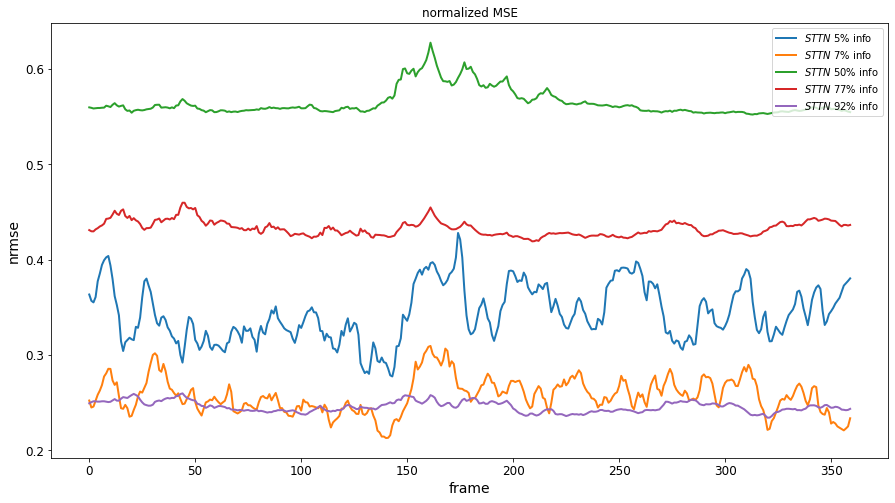

In [230]:
# plot nRMSE time series
mean = nrmse.mean()
std = nrmse.std()
N=len(nrmse)
plt.figure(figsize=(15,8))
plt.plot(range(N),nrmse_5,linestyle='solid',linewidth=2,label=r"$STTN$ 5% info")
plt.plot(range(N),nrmse_7,linestyle='solid',linewidth=2,label=r"$STTN$ 7% info")
plt.plot(range(N),nrmse_50,linestyle='solid',linewidth=2,label=r"$STTN$ 50% info")
plt.plot(range(N),nrmse_77,linestyle='solid',linewidth=2,label=r"$STTN$ 77% info")
plt.plot(range(N),nrmse_92,linestyle='solid',linewidth=2,label=r"$STTN$ 92% info")

# plt.plot(range(N),nrmse_7,linestyle='solid',color='blue',linewidth=2,label=r"$STTN$ 7% info")

plt.title('normalized MSE')
plt.xlabel('frame')
plt.ylabel('nrmse')
plt.legend()
plt.show()


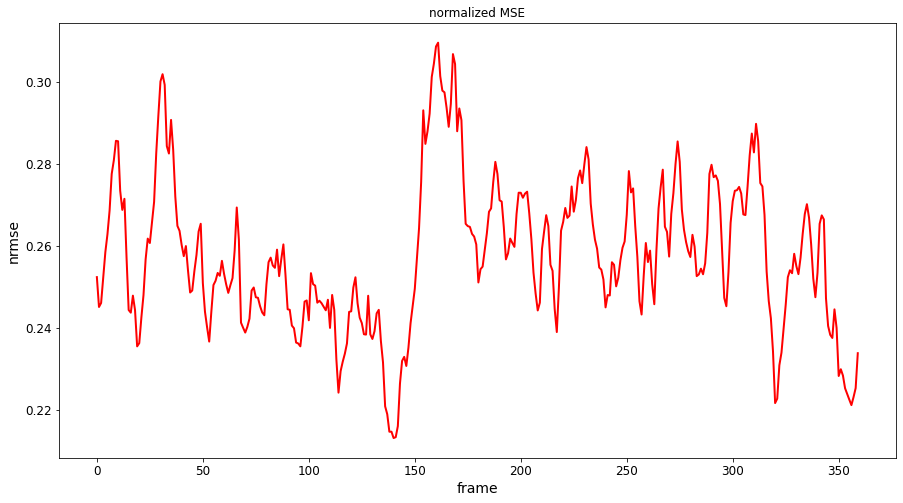

In [443]:
# plot nRMSE time series
mean = nrmse.mean()
std = nrmse.std()
N=len(nrmse)
plt.figure(figsize=(15,8))
plt.plot(range(N),nrmse,linestyle='solid',color='red',linewidth=2,label=r"$STTN$")
plt.title('normalized MSE')
plt.xlabel('frame')
plt.ylabel('nrmse')
plt.show()


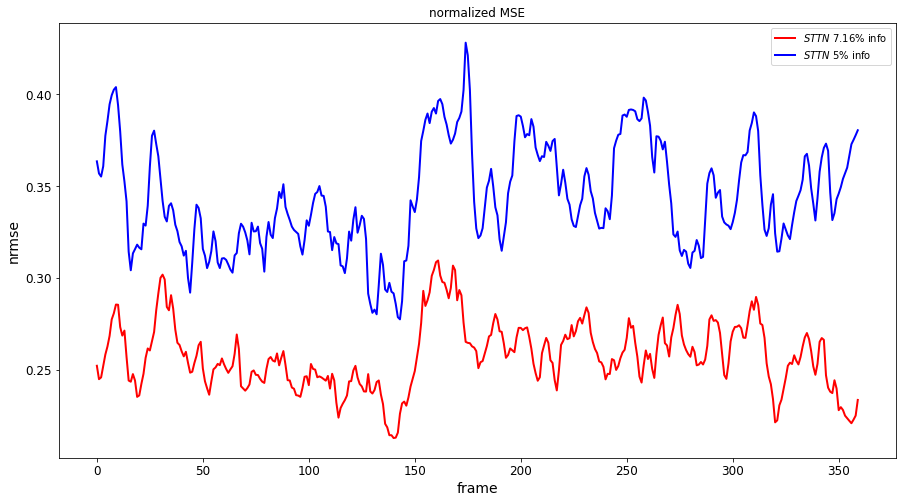

In [444]:
# plot nRMSE time series
mean = nrmse.mean()
std = nrmse.std()
N=len(nrmse)
plt.figure(figsize=(15,8))
plt.plot(range(N),nrmse,linestyle='solid',color='red',linewidth=2,label=r"$STTN$ 7.16% info")
plt.plot(range(N),nrmse_5,linestyle='solid',color='blue',linewidth=2,label=r"$STTN$ 5% info")

plt.title('normalized MSE')
plt.xlabel('frame')
plt.ylabel('nrmse')
plt.legend()
plt.show()


In [445]:
nrmse_7 = nrmse.copy()

In [417]:
nrmse_5 = nrmse.copy()

In [446]:
print('Mean :',mean, 'std :',std)

Mean : 0.25768118863447614 std : 0.018463006815929595


In [169]:
# stationnary masks ->

# cacher des frames 

# utiliser nos masques sur des videos youtube ->

# reconsistuer une seule image dans une video avec nos masques

# prendre du recul et decider une stratégie

# métrique : PSD 

In [170]:
writer = cv2.VideoWriter(path+f"ssh_result_experiment{experiment}.mp4", cv2.VideoWriter_fourcc(*"mp4v"), default_fps, (w, h))
for f in range(video_length):
    comp = np.array(comp_frames[f]).astype(
        np.uint8)*binary_masks[f] + frames[f] * (1-binary_masks[f])
    writer.write(cv2.cvtColor(np.array(comp).astype(np.uint8), cv2.COLOR_BGR2RGB))
writer.release()
print('Finish in {}'.format(path+f"ssh_result_experiment{experiment}.mp4"))

Finish in Experiments/Experiment9/ssh_result_experiment9.mp4


- Lancer le modele sur nos données avec les masques de l'auteur
- enlever les frames avec un masque tres grand
- fine tuner sur differentes videos avec nos masques 
- documenter et rédiger les différentes experiences

In [328]:
m_p = masks[0][frame][0].cpu()
m = np.array(m_p)
masks_cover = ((m==255).sum()/(m.shape[0]*m.shape[1]))

## Visualize results 7.16%

In [66]:
dataset_path = '../datasets/'
lon = xr.open_dataset(dataset_path + "ref.nc").lon.values[5:197]
lat = xr.open_dataset(dataset_path + "ref.nc").lat.values[5:197]
extent = [np.min(lon),np.max(lon),np.min(lat),np.max(lat)]

In [232]:
for frame in np.where(nrmse<0.05)[0][:20]:
    print(f'---------- frame {frame}--------------')
    print(f'NRMSE : {nrmse[frame]}')
    plt.figure(figsize=(5,5))
    plt.imshow(masks[0][frame][0].cpu())

    fig, ax = plt.subplots(1,2,squeeze=False,
                            subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0)))

    plot(ax,0,0,lon,lat,gt[frame], r"$GT$",\
                 extent=extent,cmap='viridis',vmin=minn,vmax=maxx)

    plot(ax,0,1,lon,lat,prediction_ssh[frame], r"$Predictions$",\
                 extent=extent,cmap='viridis',vmin=minn,vmax=maxx)
    plt.show()

---------- frame 0--------------
Performance : 0.12859038387837424


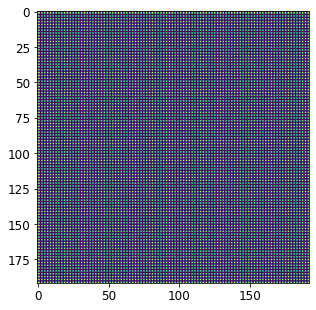

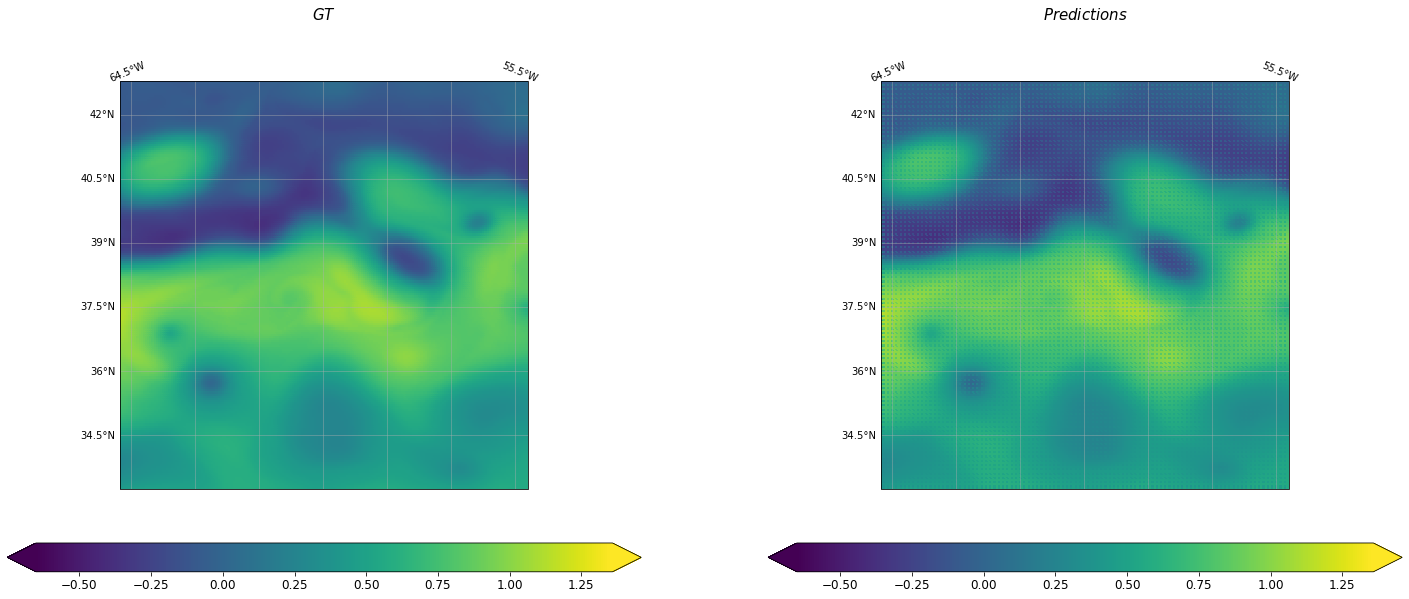

---------- frame 1--------------
Performance : 0.12850632490643507


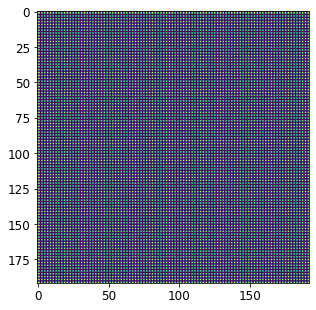

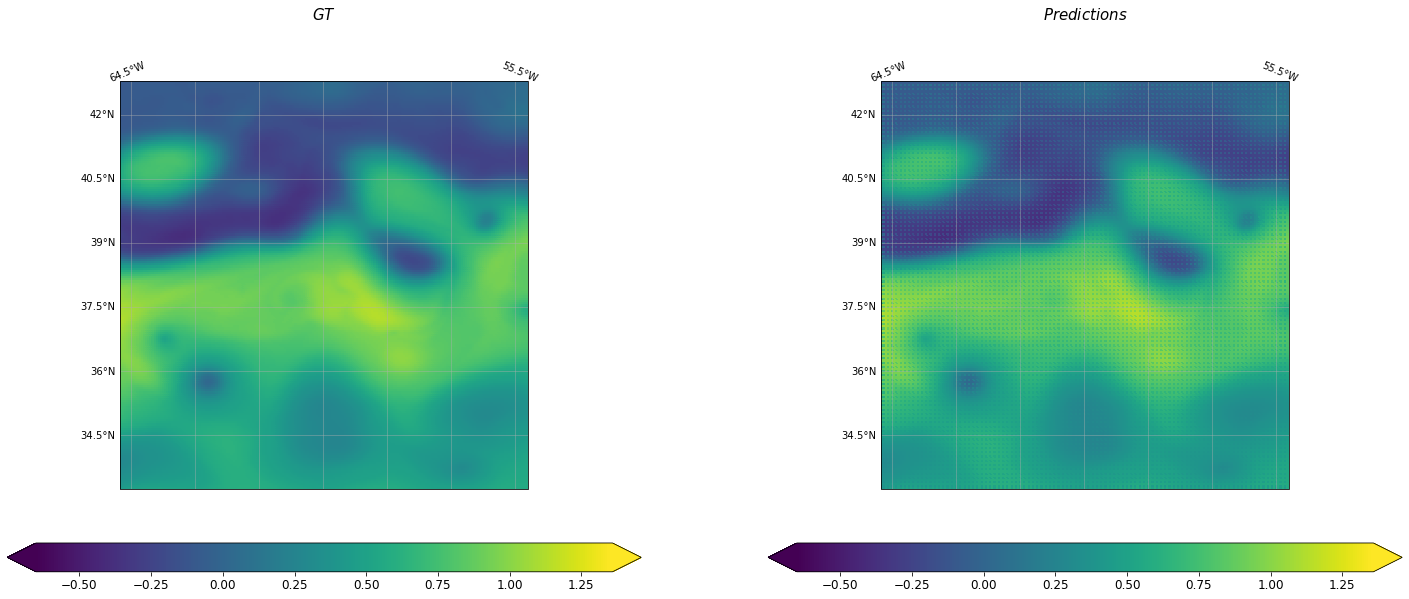

---------- frame 2--------------
Performance : 0.12756159539339687


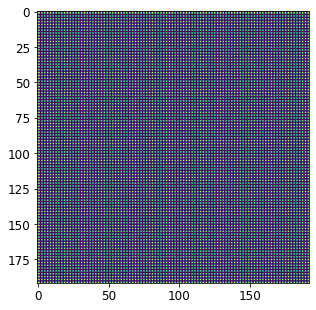

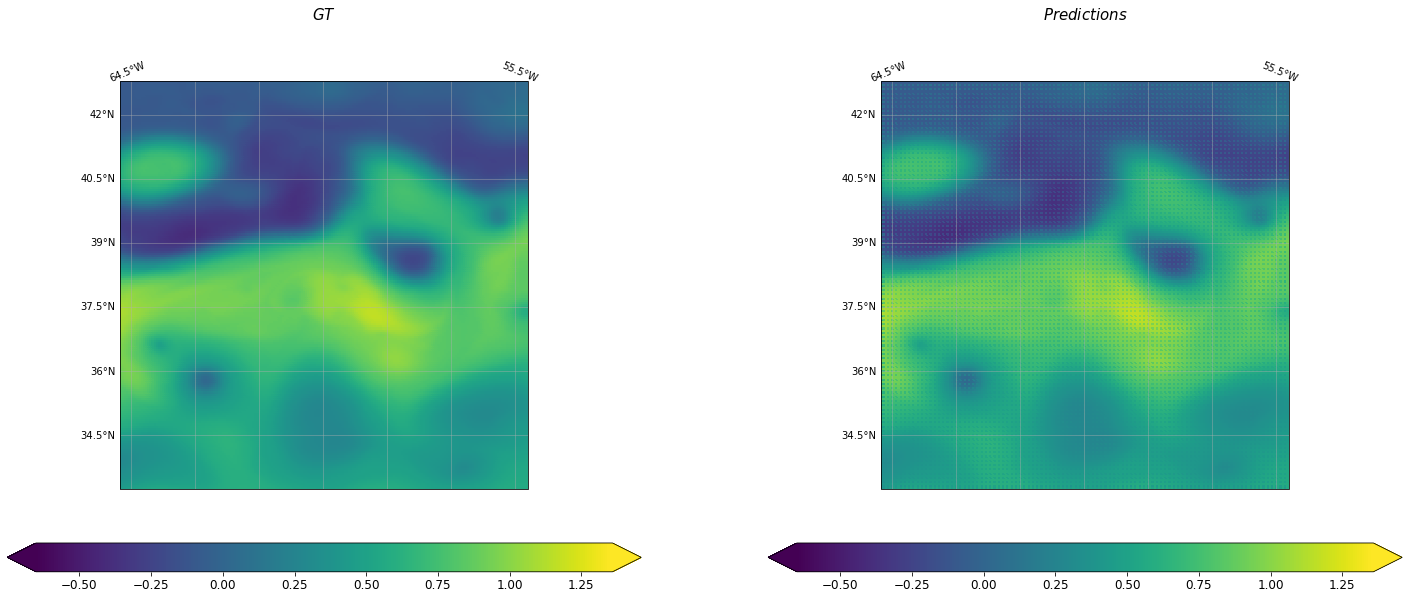

---------- frame 3--------------
Performance : 0.12708141326225847


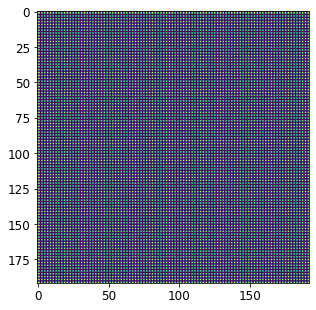

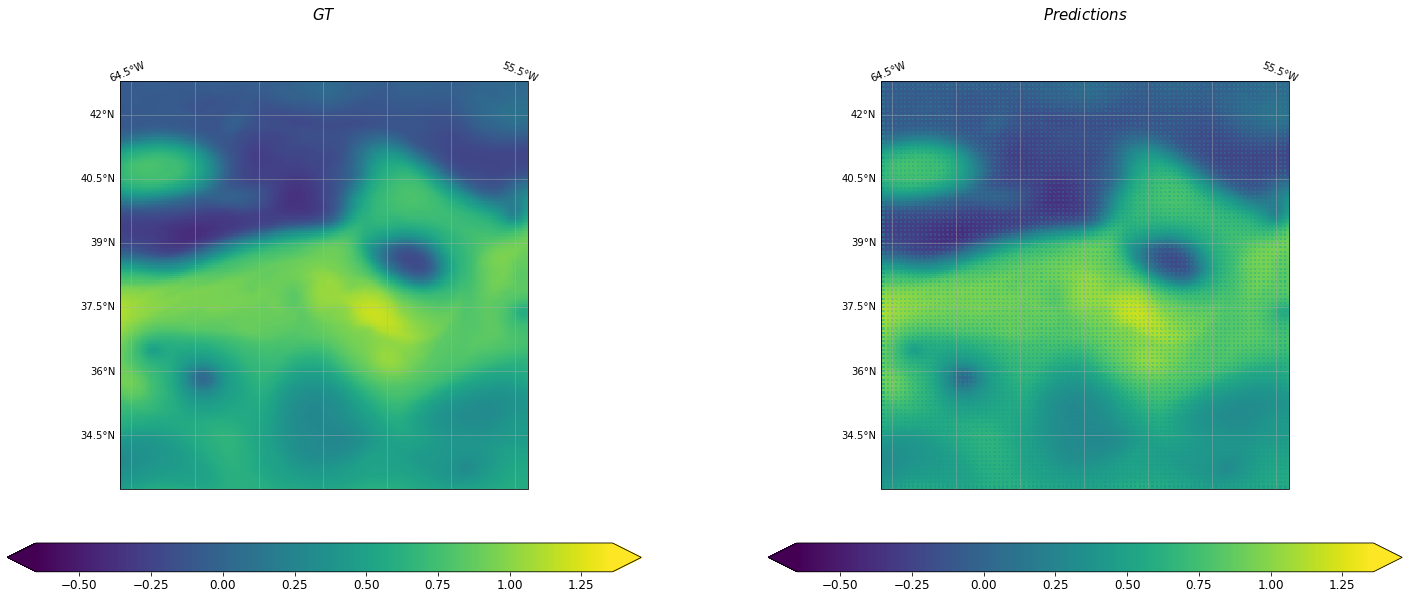

---------- frame 4--------------
Performance : 0.1269248771548485


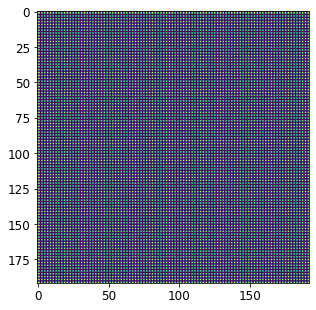

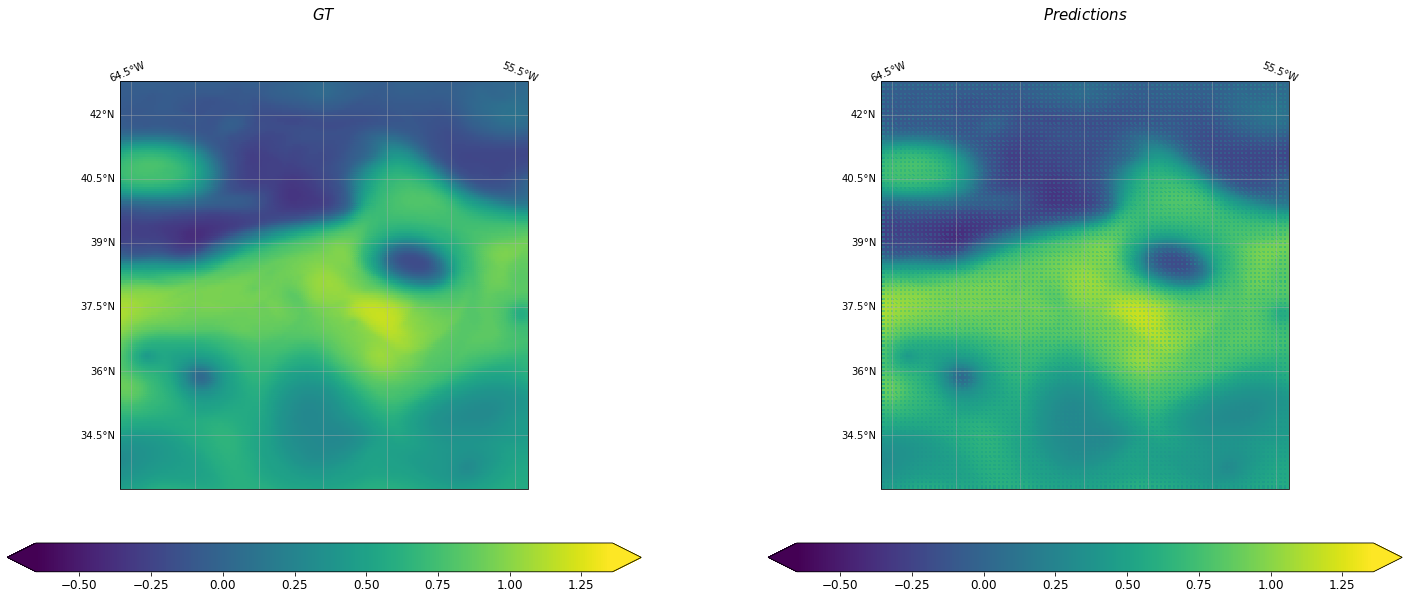

---------- frame 5--------------
Performance : 0.1268406906331101


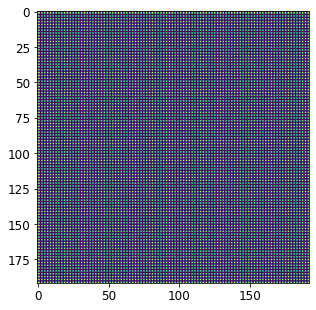

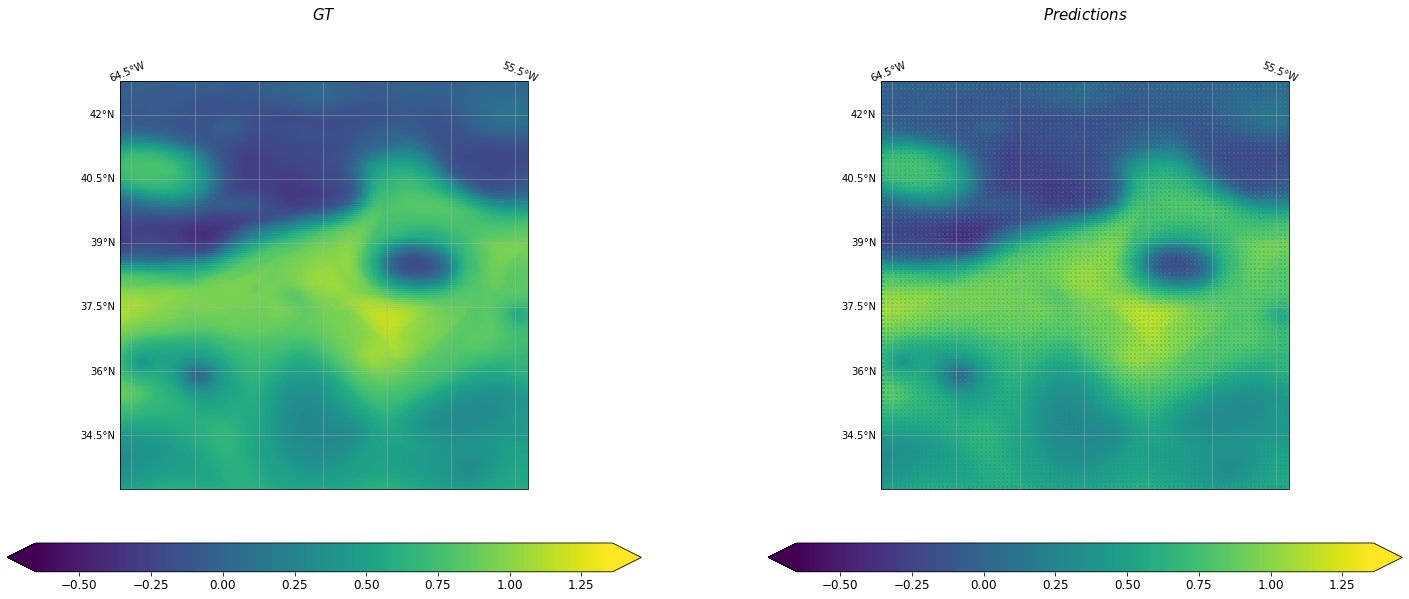

---------- frame 6--------------
Performance : 0.12666726721284585


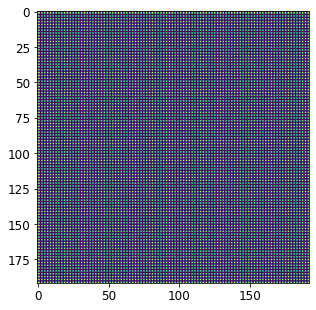

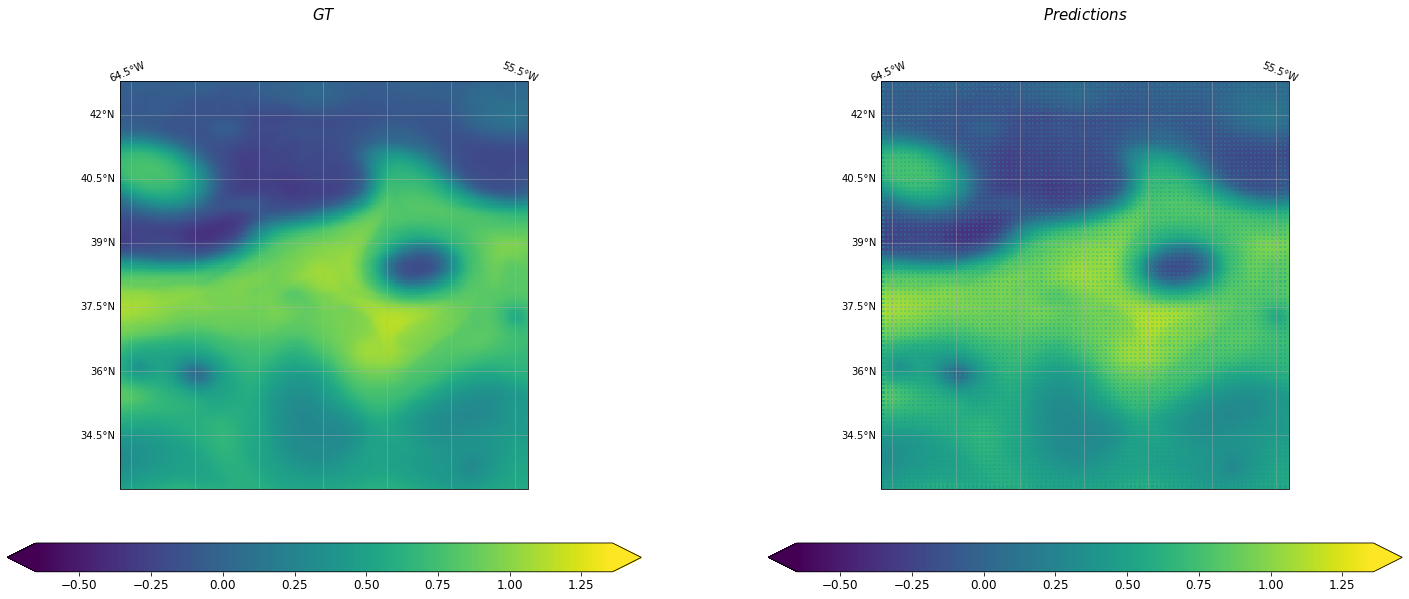

---------- frame 7--------------
Performance : 0.12620543418548477


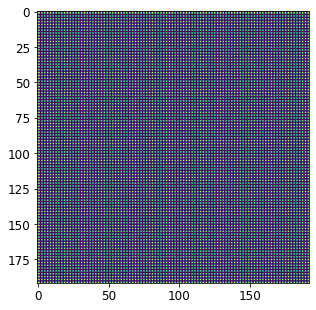

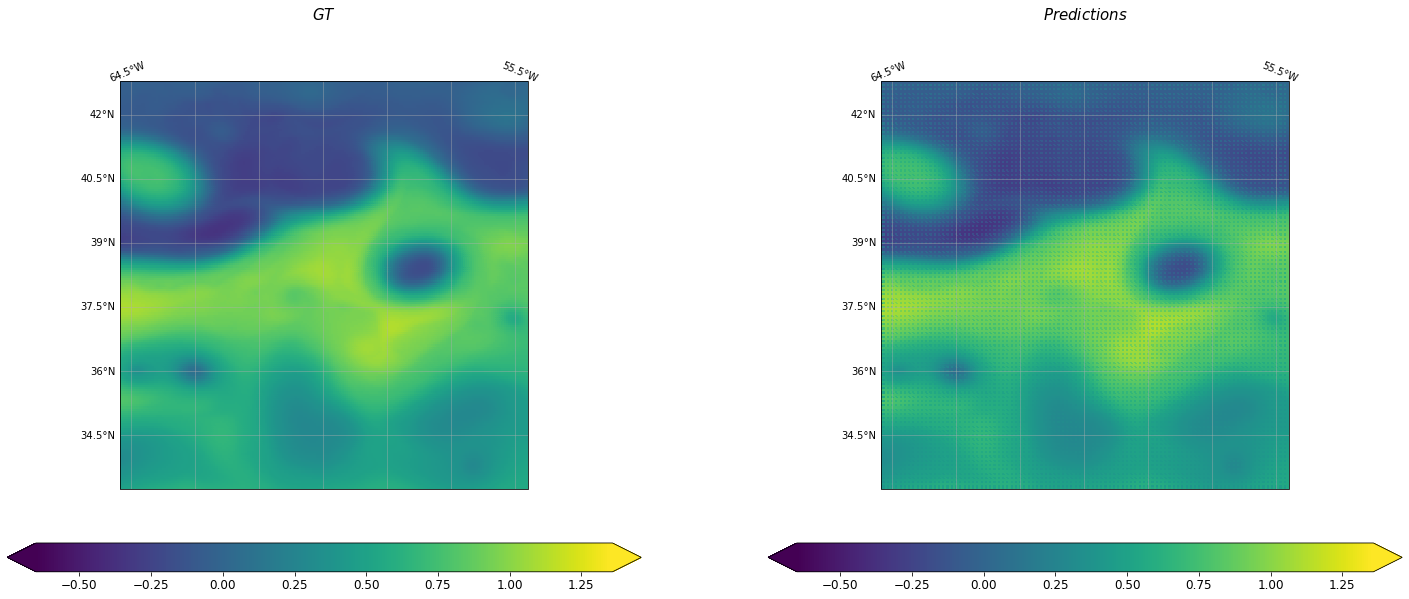

---------- frame 8--------------
Performance : 0.12642081058374205


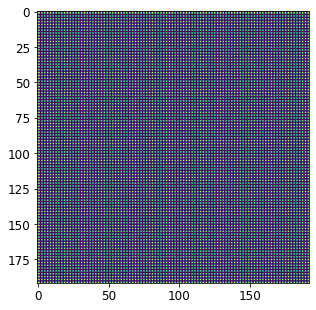

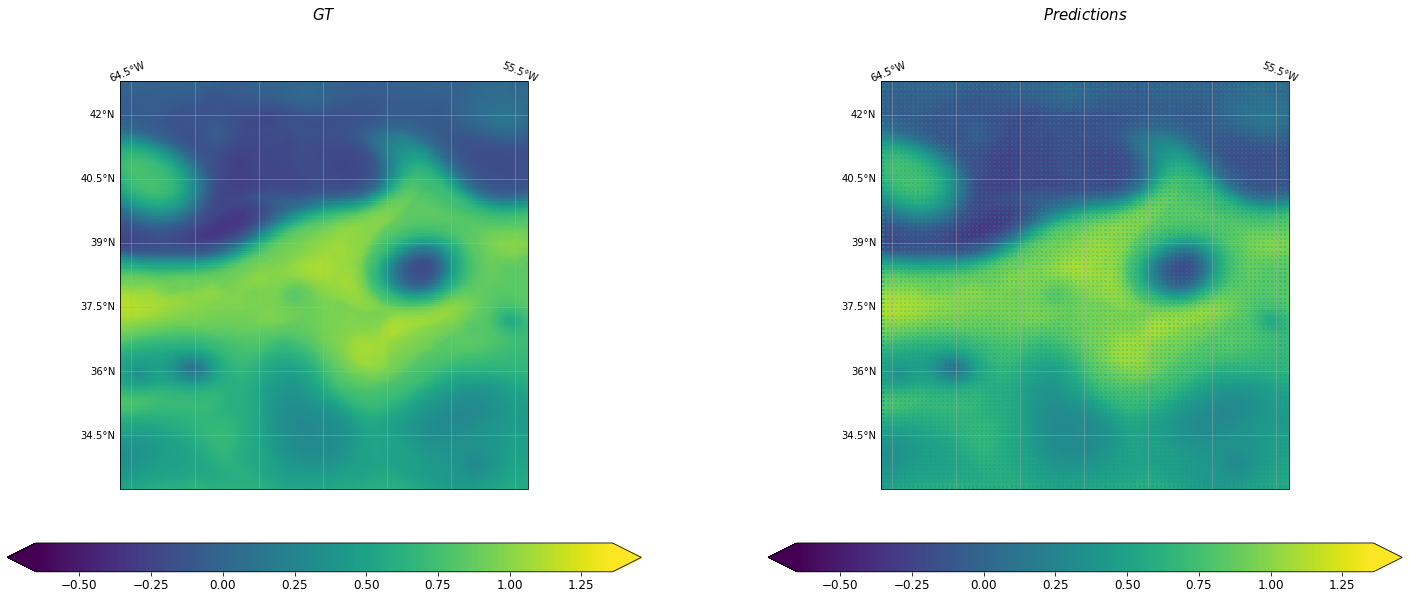

---------- frame 9--------------
Performance : 0.1258606578984469


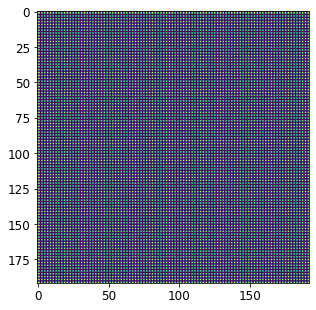

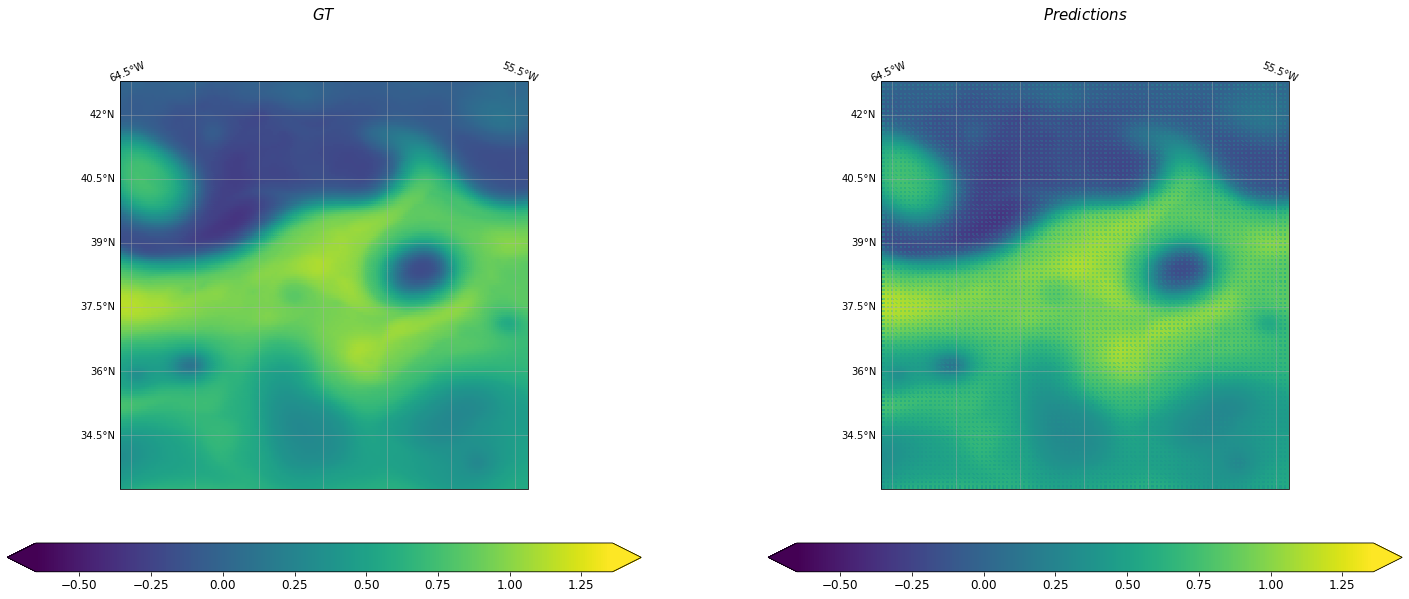

---------- frame 10--------------
Performance : 0.1253857998399227


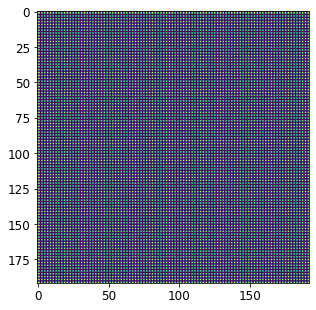

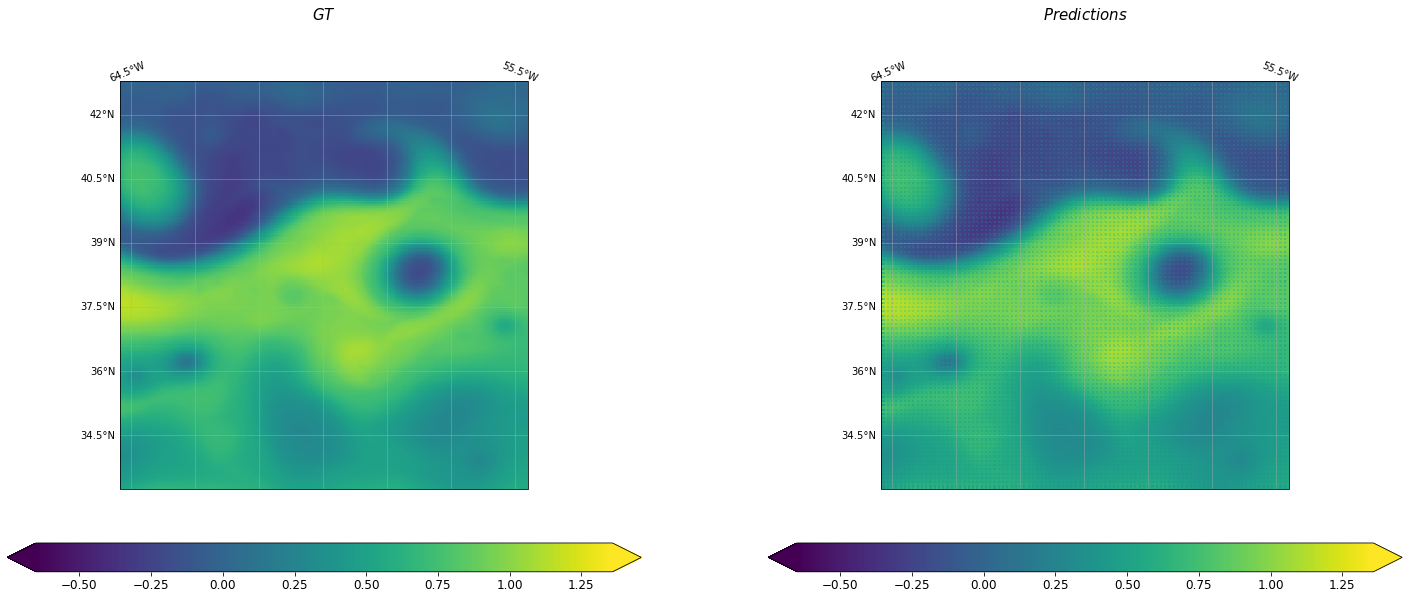

---------- frame 11--------------
Performance : 0.12546907190874526


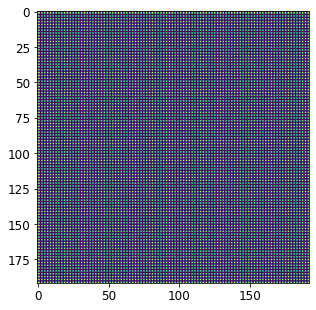

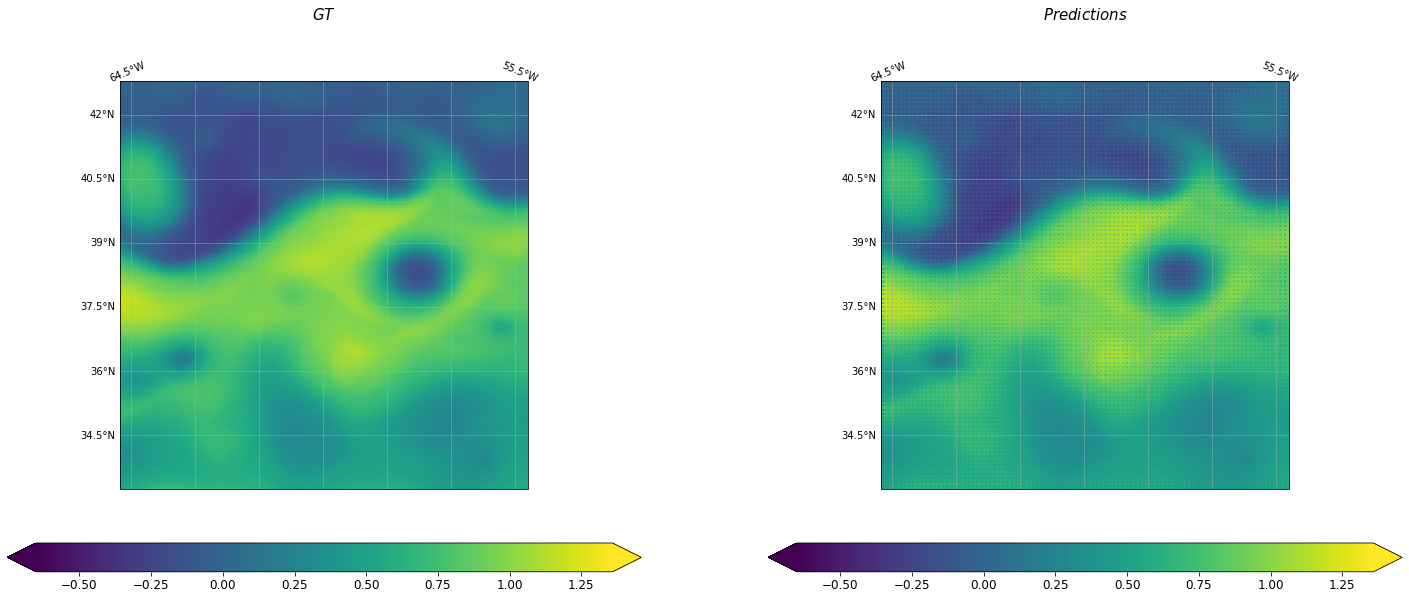

---------- frame 12--------------
Performance : 0.12564767310046773


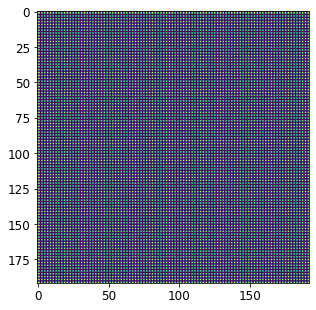

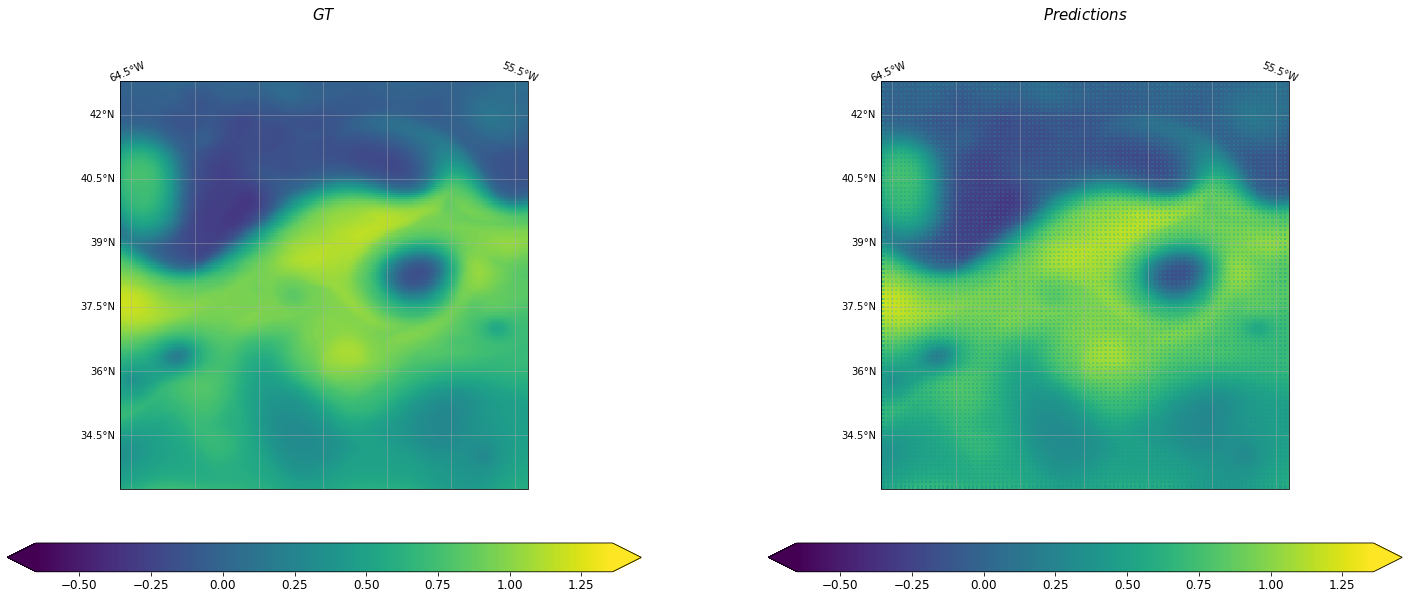

---------- frame 13--------------
Performance : 0.1255084972319796


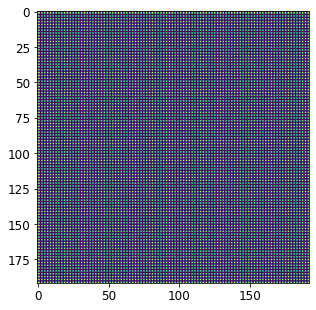

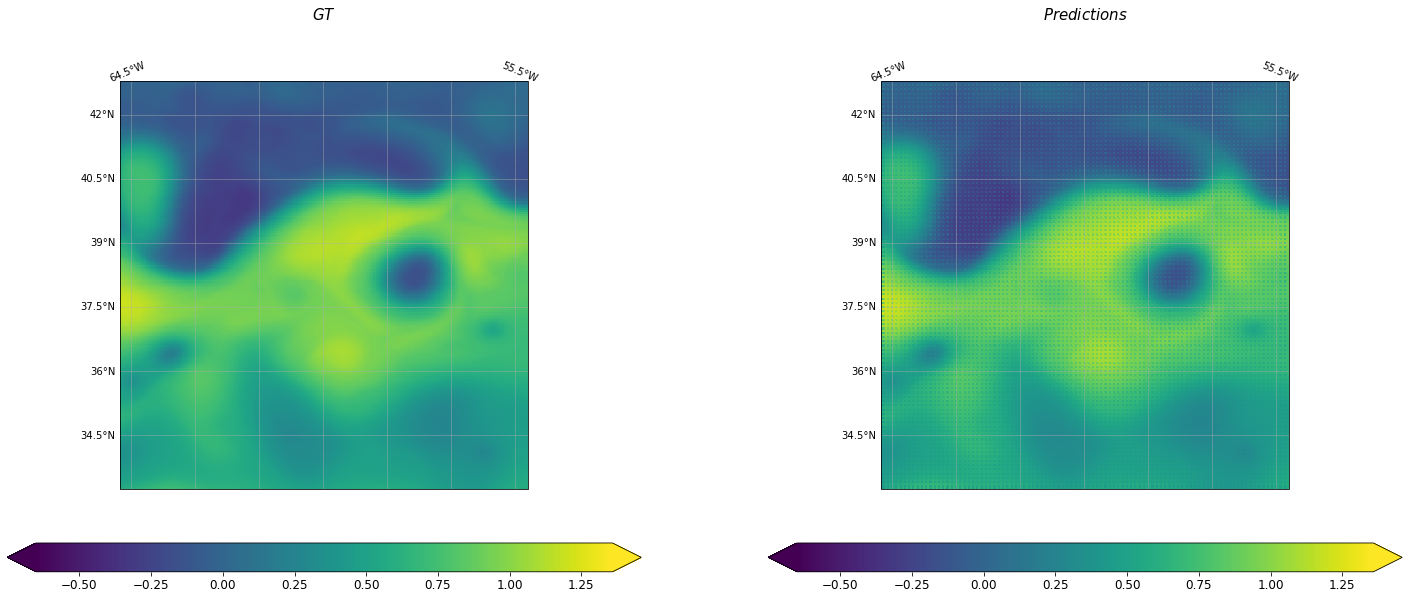

---------- frame 14--------------
Performance : 0.12567715535390037


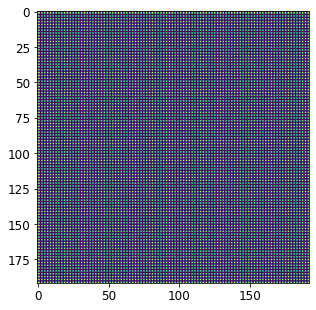

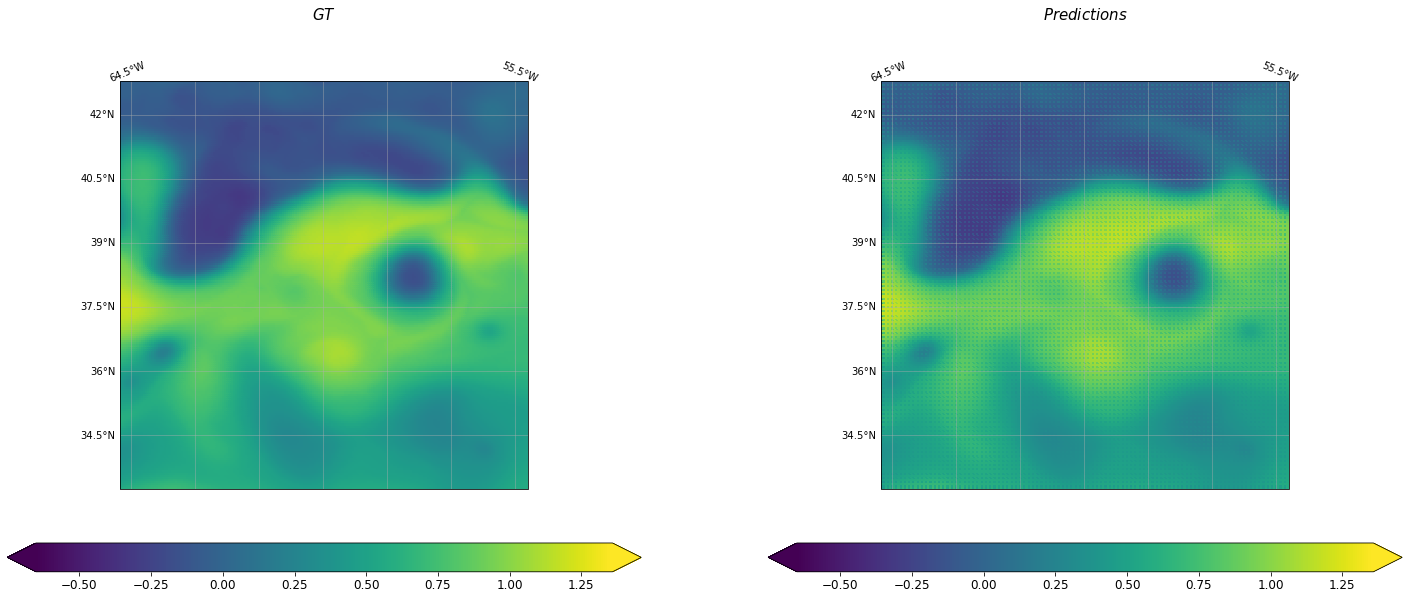

---------- frame 15--------------
Performance : 0.1261733881844352


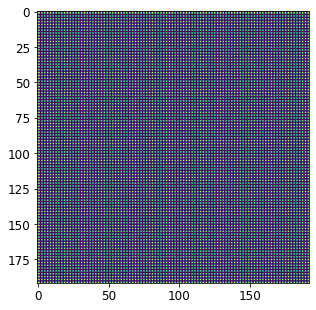

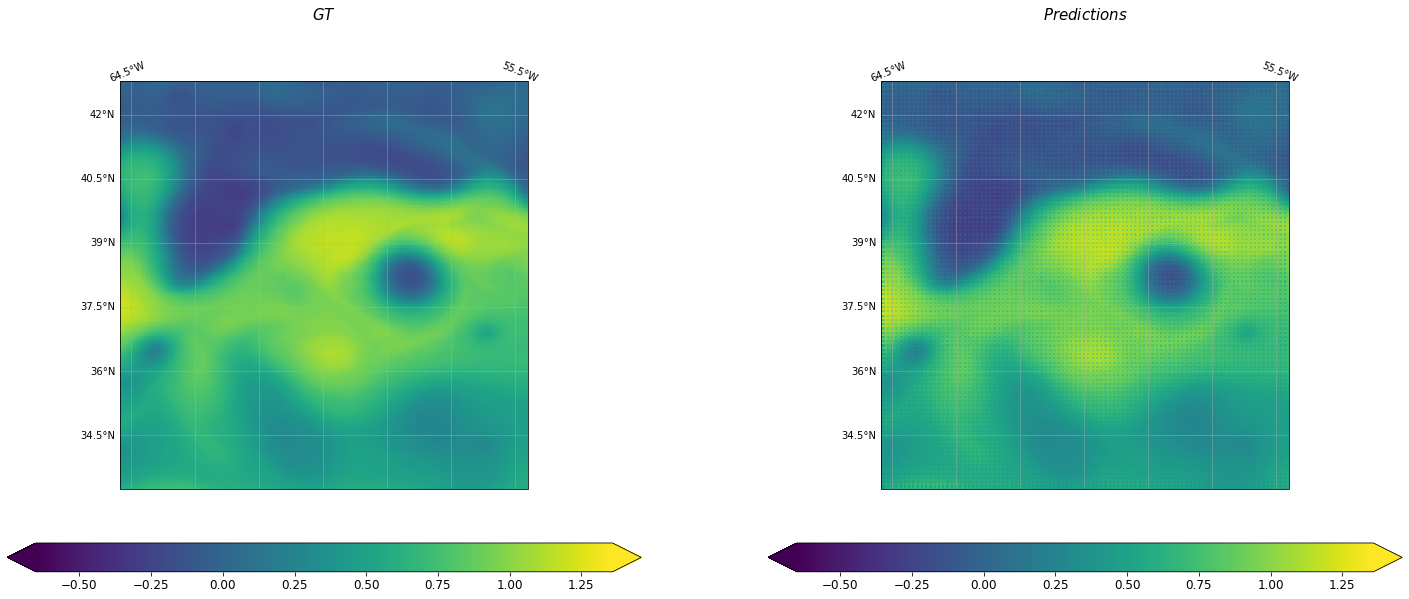

---------- frame 16--------------
Performance : 0.12620804572858008


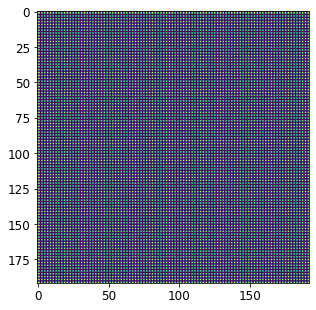

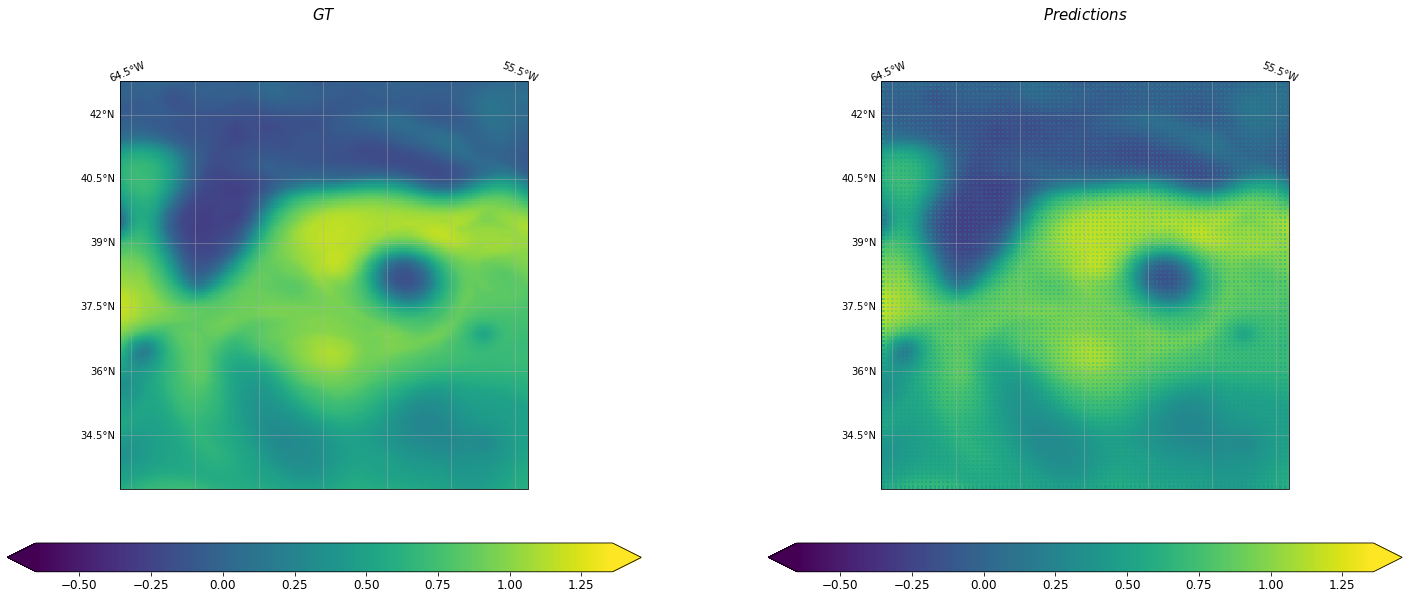

---------- frame 17--------------
Performance : 0.12531756776096373


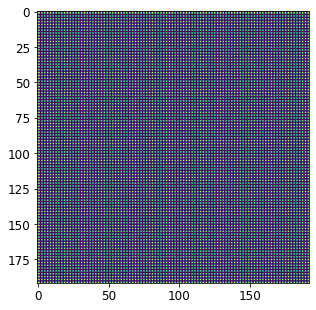

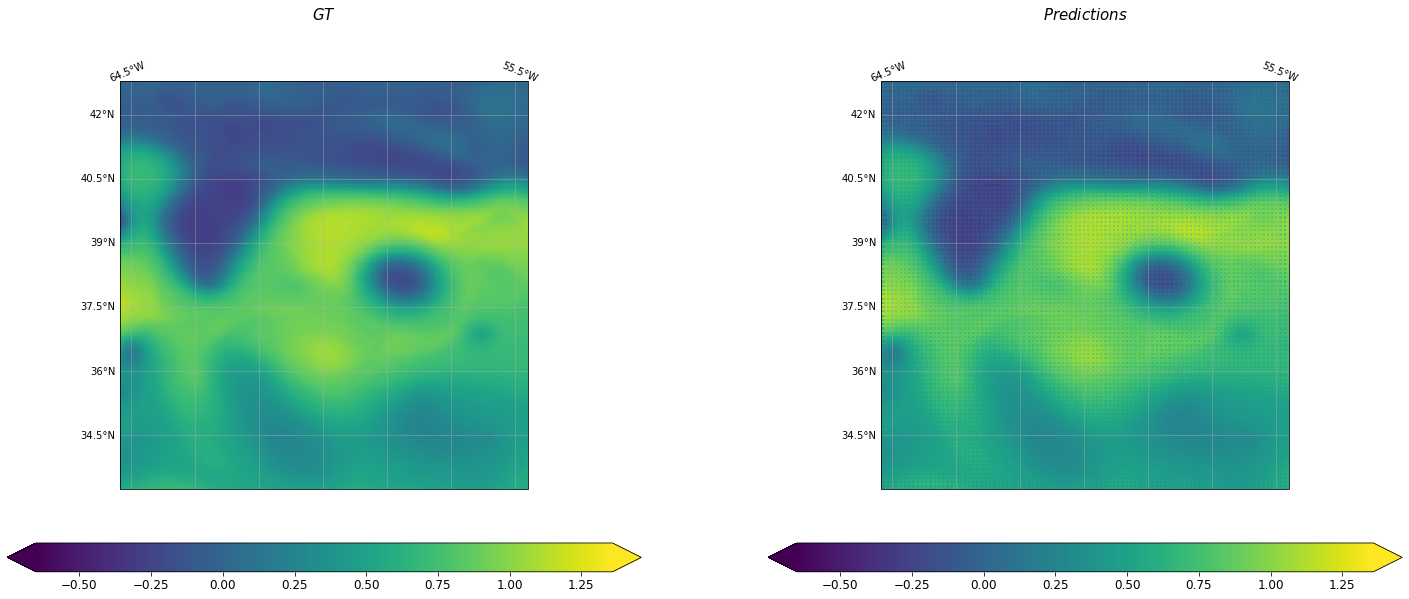

---------- frame 18--------------
Performance : 0.12531139202591385


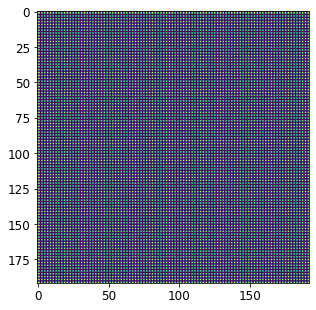

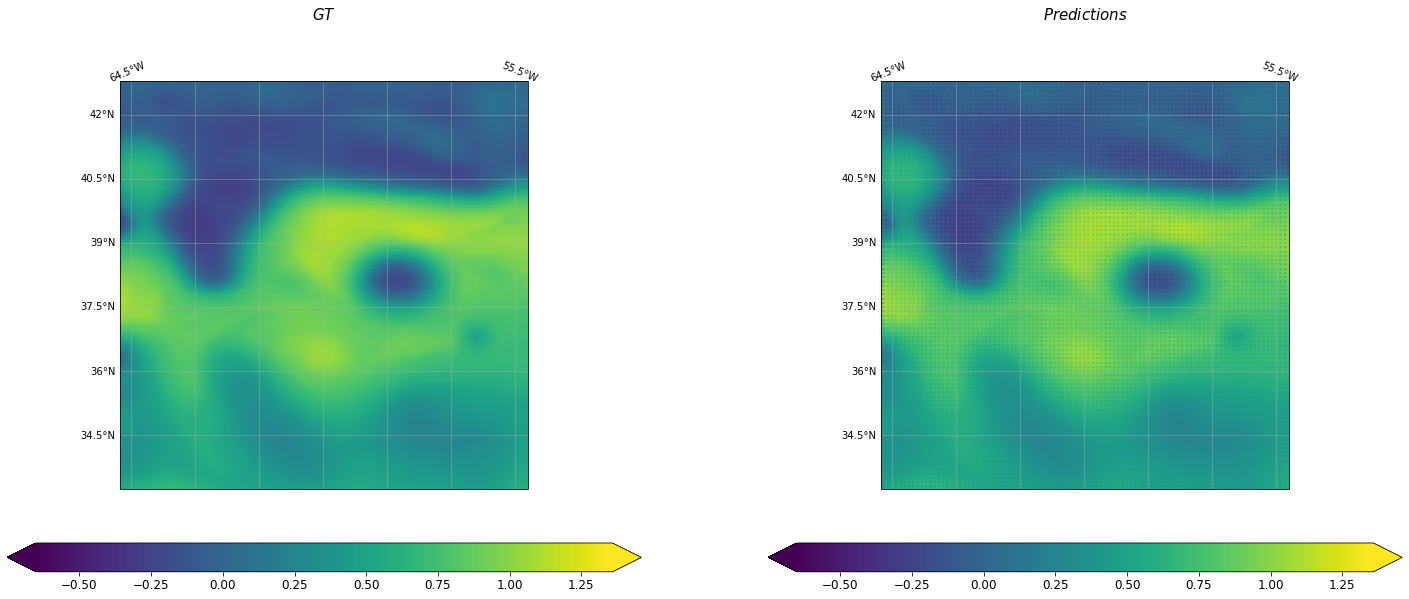

---------- frame 19--------------
Performance : 0.1259931927774751


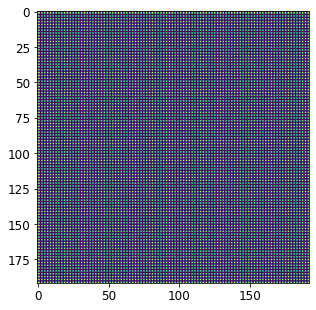

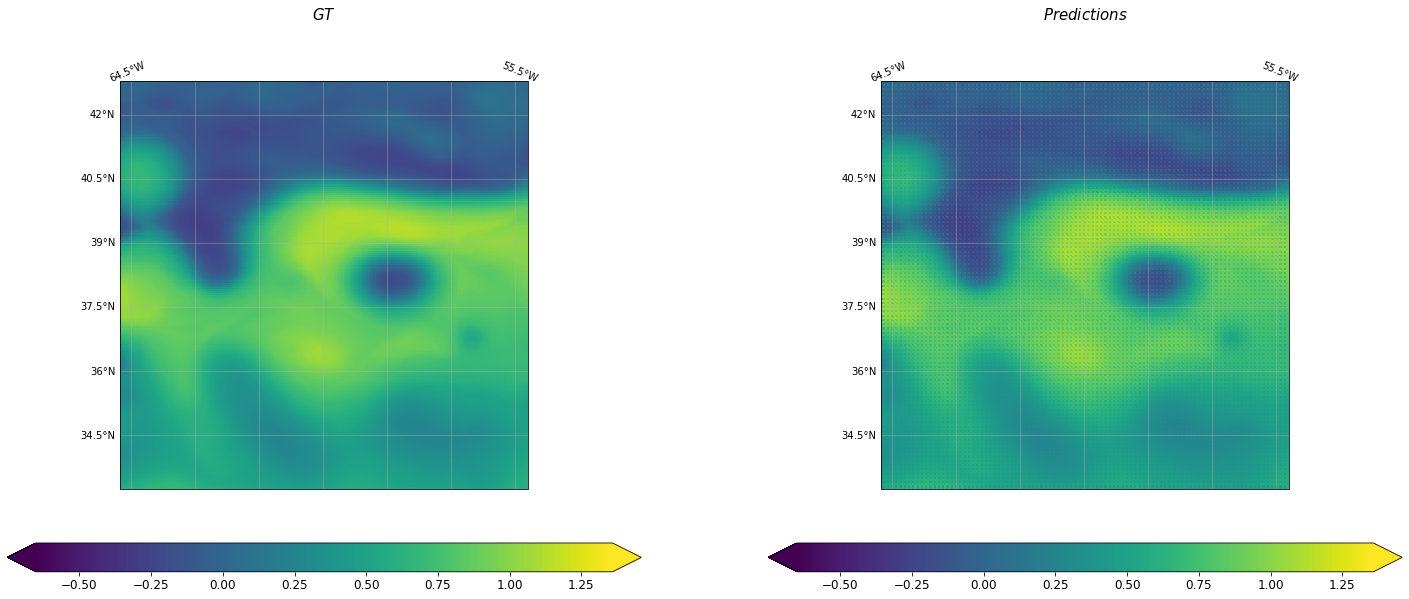

In [69]:
for frame in np.where(nrmse>0)[0][:20]:
    print(f'---------- frame {frame}--------------')
    print(f'Performance : {nrmse[frame]}')

    plt.figure(figsize=(5,5))
    plt.imshow(masks[0][frame][0].cpu())

    fig, ax = plt.subplots(1,2,squeeze=False,
                            subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0)))

    plot(ax,0,0,lon,lat,gt[frame], r"$GT$",\
                 extent=extent,cmap='viridis',vmin=minn,vmax=maxx)

    plot(ax,0,1,lon,lat,prediction_ssh[frame], r"$Predictions$",\
                 extent=extent,cmap='viridis',vmin=minn,vmax=maxx)
    plt.show()

## Visualize results 5%

In [34]:
dataset_path = '../datasets/'
lon = xr.open_dataset(dataset_path + "ref.nc").lon.values[5:197]
lat = xr.open_dataset(dataset_path + "ref.nc").lat.values[5:197]
extent = [np.min(lon),np.max(lon),np.min(lat),np.max(lat)]

In [35]:
for frame in np.where(nrmse<0.05)[0][:20]:
    print(f'---------- frame {frame}--------------')
    print(f'NRMSE : {nrmse[frame]}')
    plt.figure(figsize=(5,5))
    plt.imshow(masks[0][frame][0].cpu())

    fig, ax = plt.subplots(1,2,squeeze=False,
                            subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0)))

    plot(ax,0,0,lon,lat,gt[frame], r"$GT$",\
                 extent=extent,cmap='viridis',vmin=minn,vmax=maxx)

    plot(ax,0,1,lon,lat,prediction_ssh[frame], r"$Predictions$",\
                 extent=extent,cmap='viridis',vmin=minn,vmax=maxx)
    plt.show()

---------- frame 0--------------
Performance : 0.3635605029378207


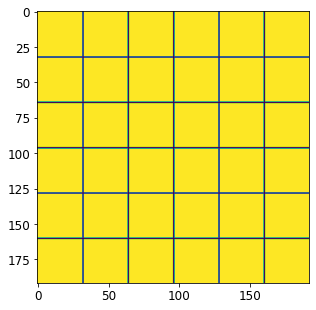

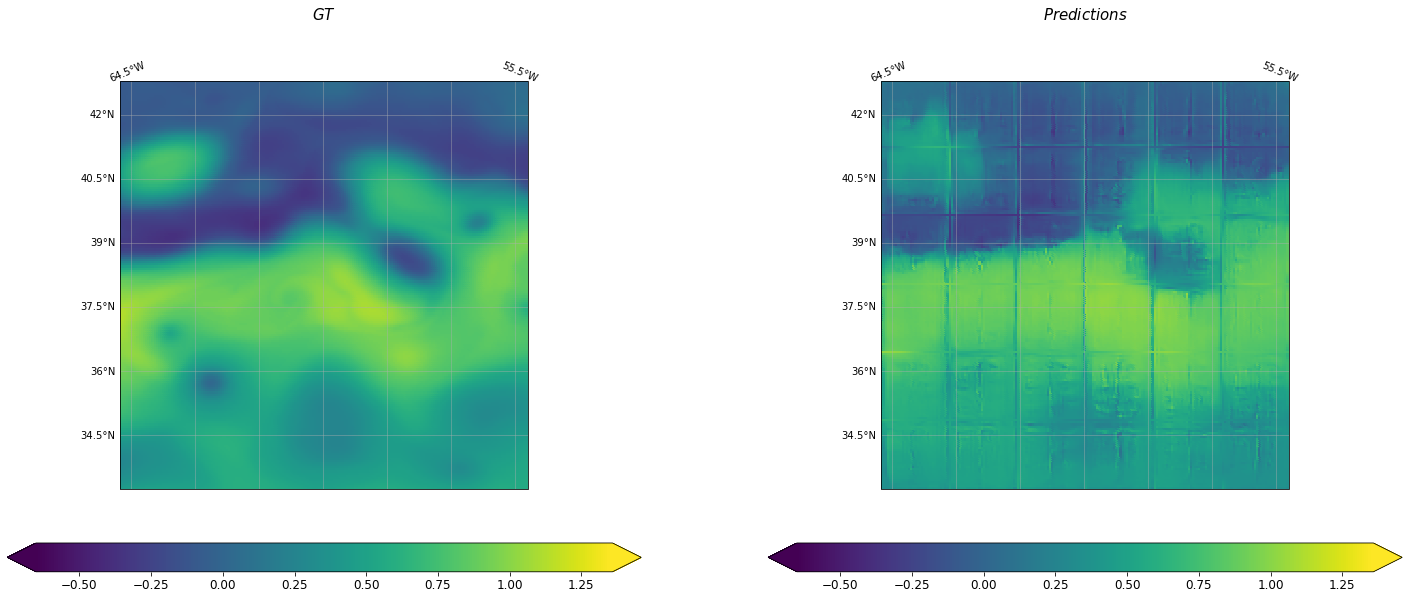

---------- frame 1--------------
Performance : 0.35697478555739265


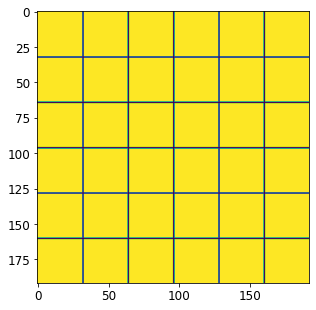

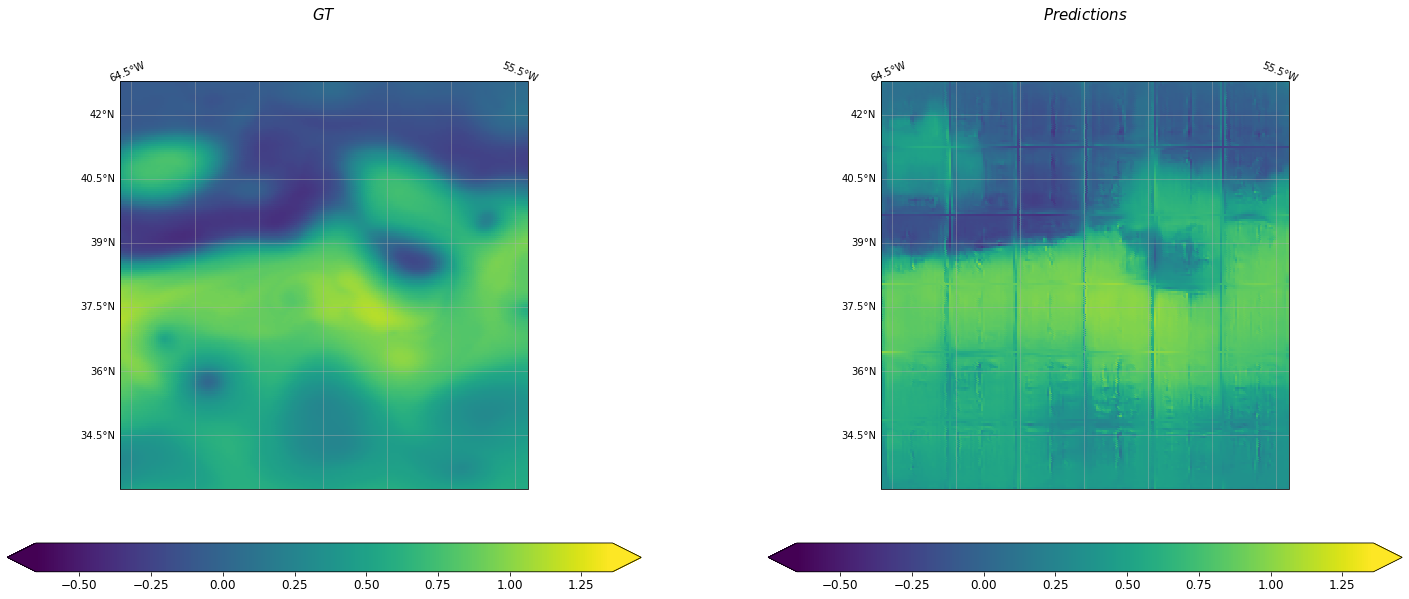

---------- frame 2--------------
Performance : 0.3552871699619055


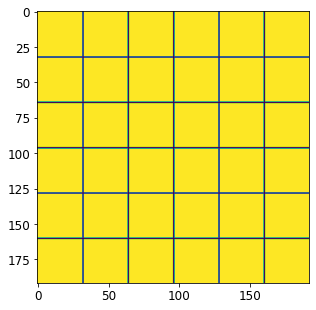

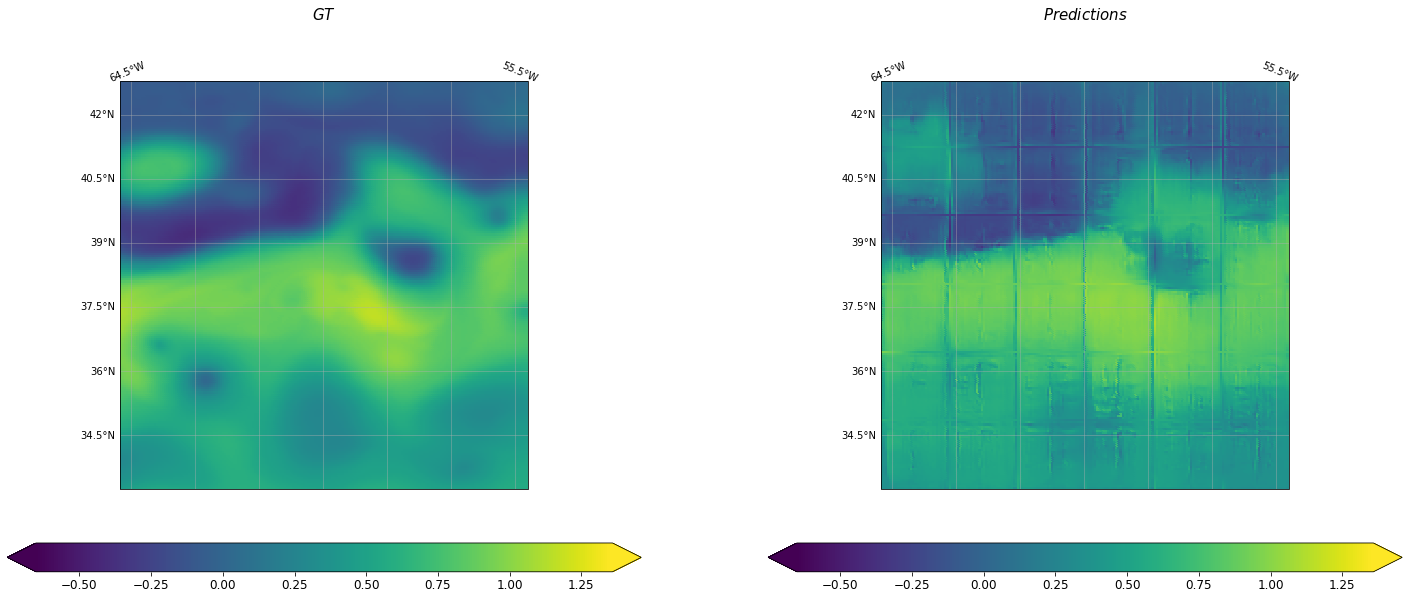

---------- frame 3--------------
Performance : 0.36089781080517747


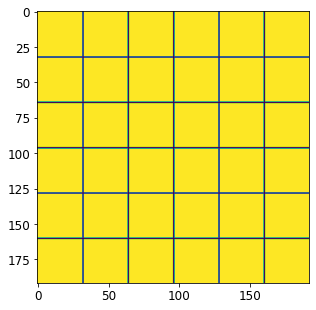

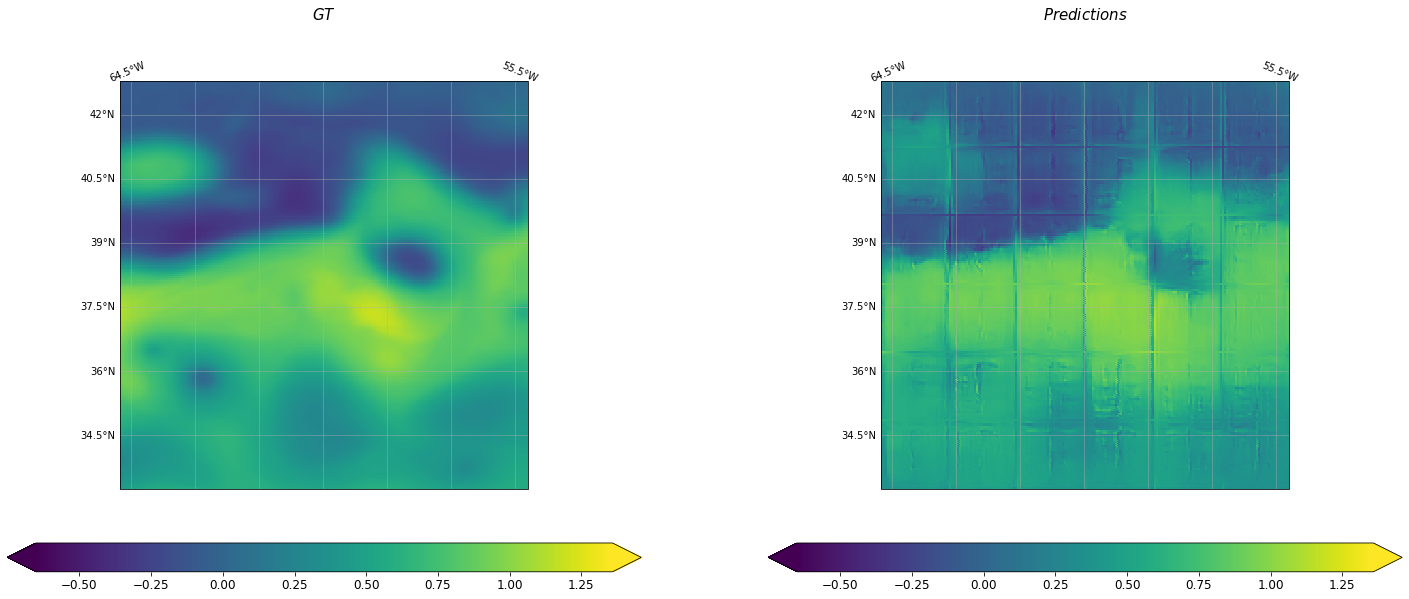

---------- frame 4--------------
Performance : 0.37748262770503366


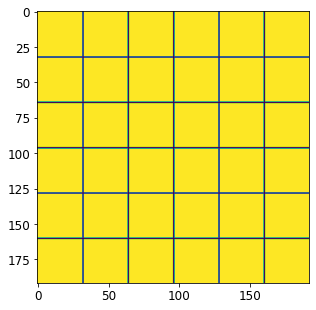

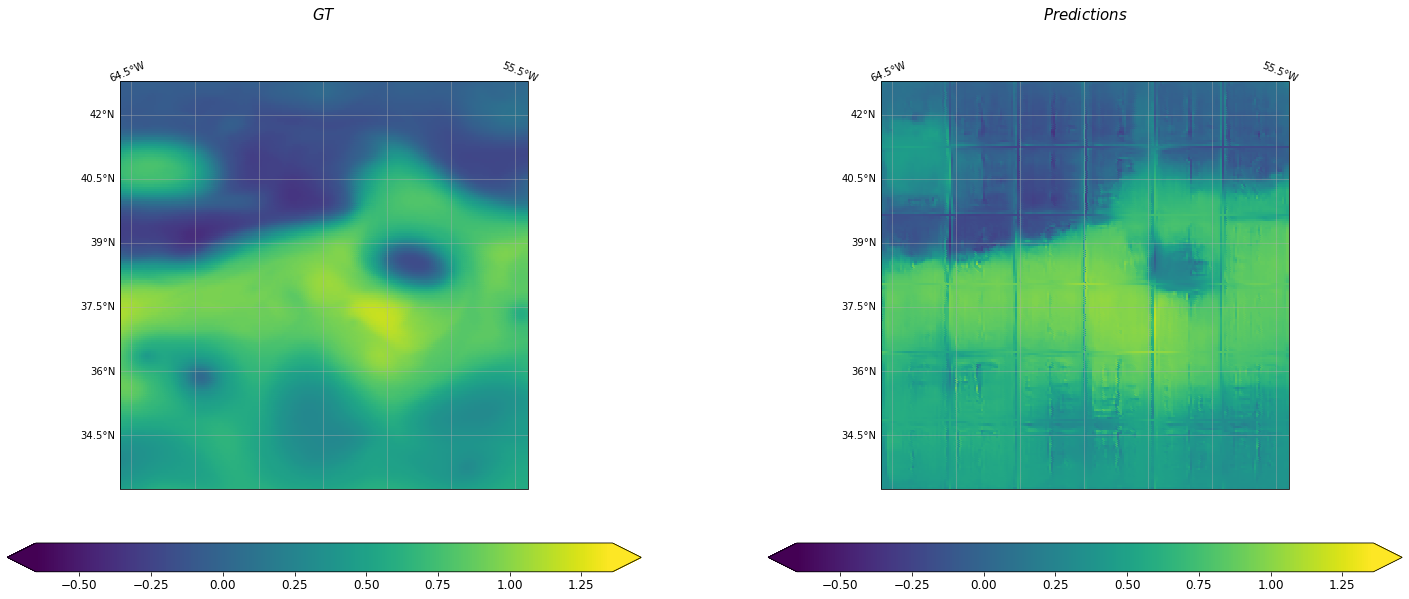

---------- frame 5--------------
Performance : 0.38557217614153816


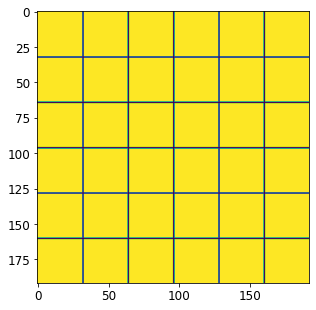

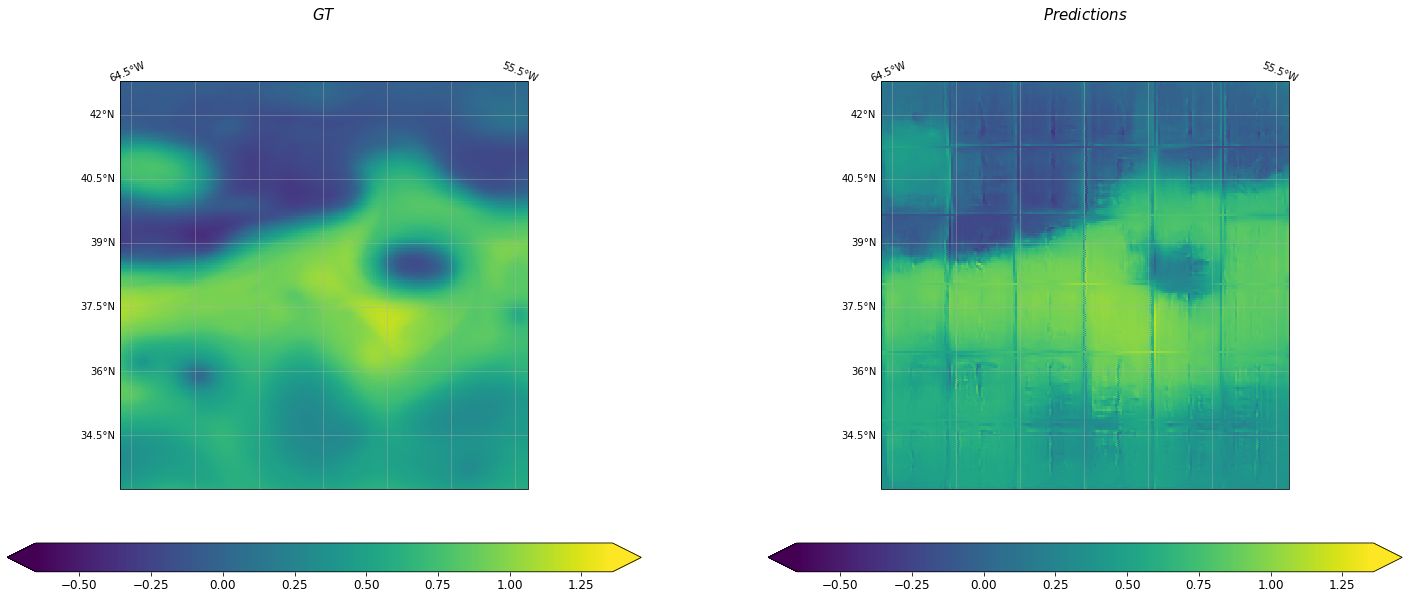

---------- frame 6--------------
Performance : 0.39459735349376257


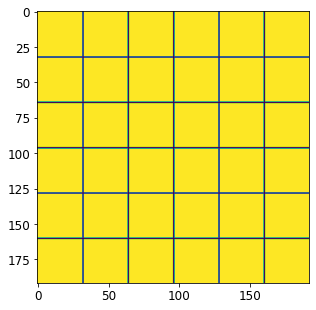

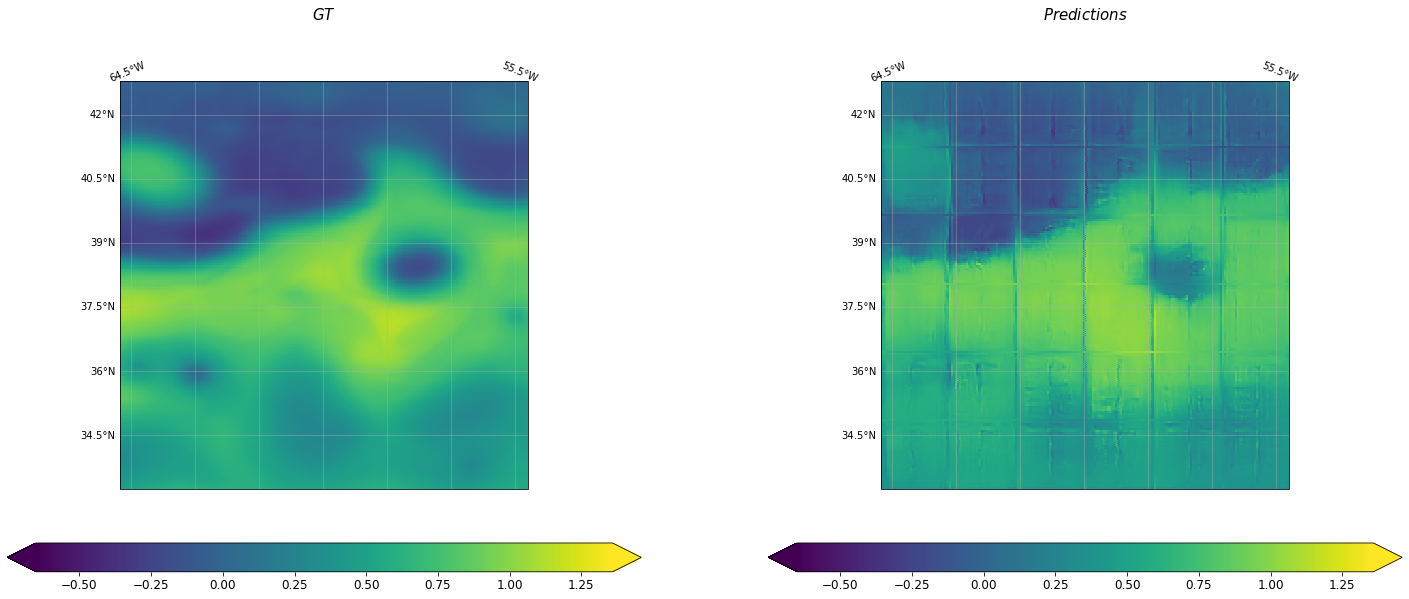

---------- frame 7--------------
Performance : 0.39950173853035675


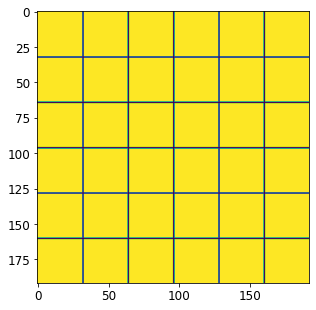

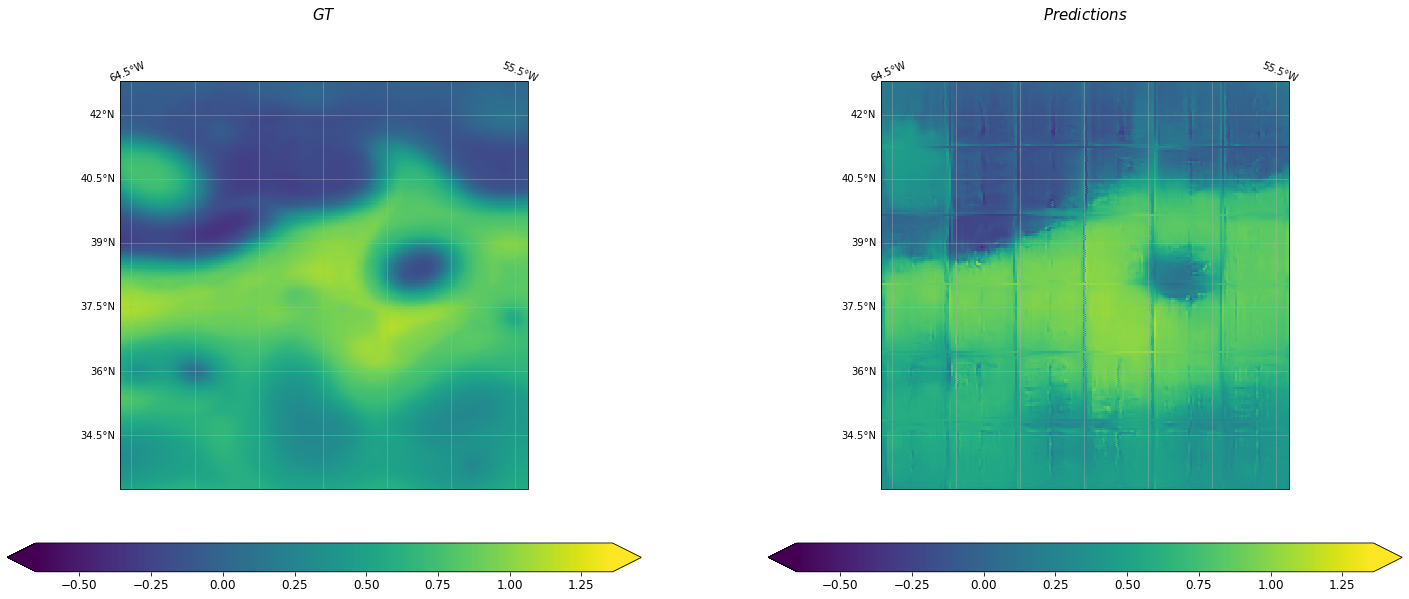

---------- frame 8--------------
Performance : 0.40253733645569556


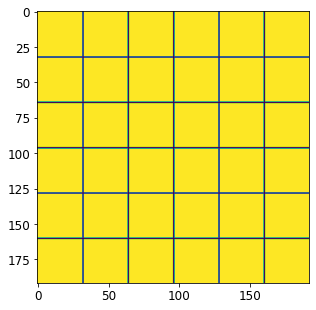

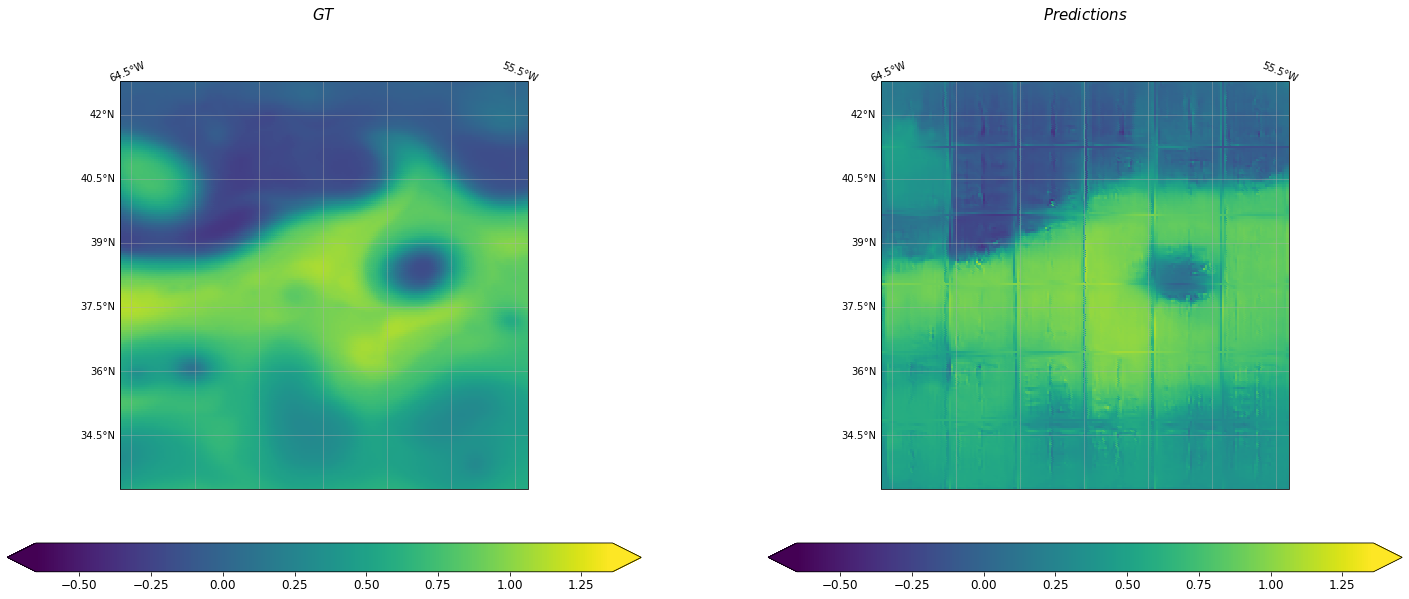

---------- frame 9--------------
Performance : 0.4039556902187339


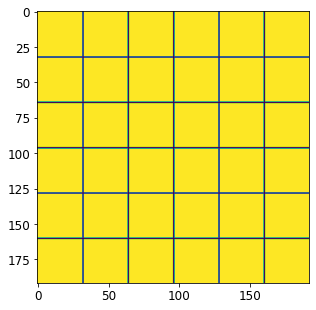

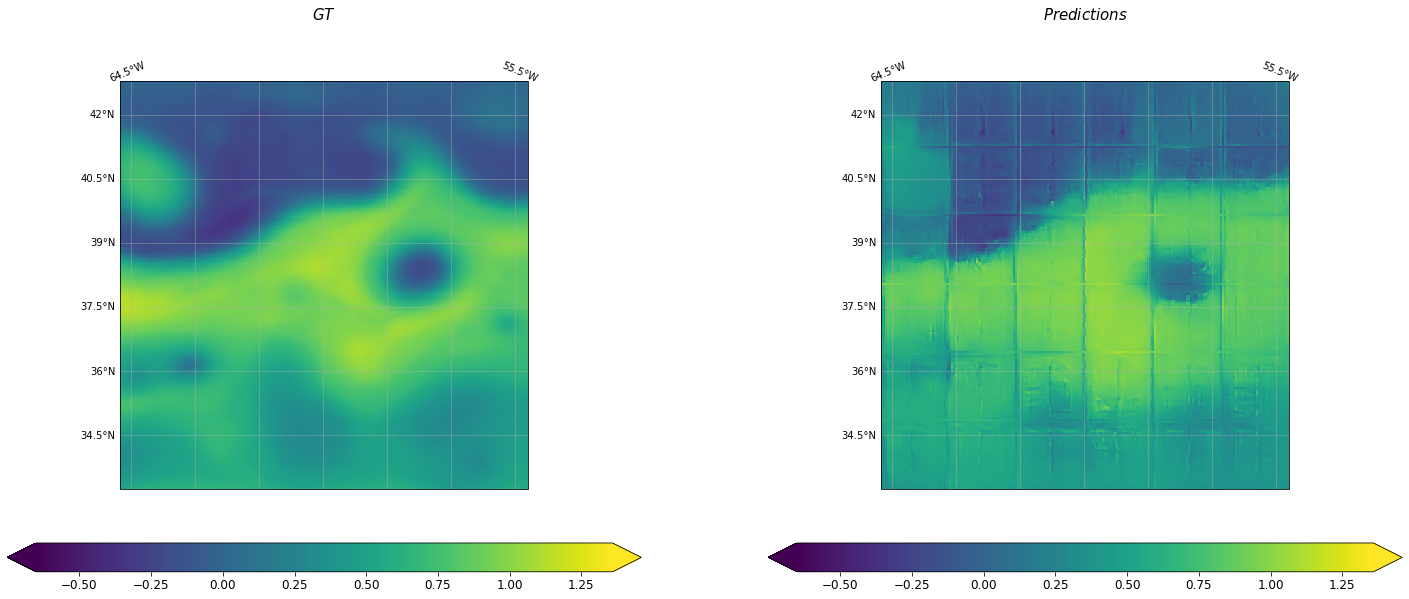

---------- frame 10--------------
Performance : 0.39405383690095575


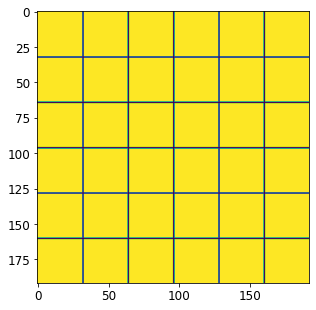

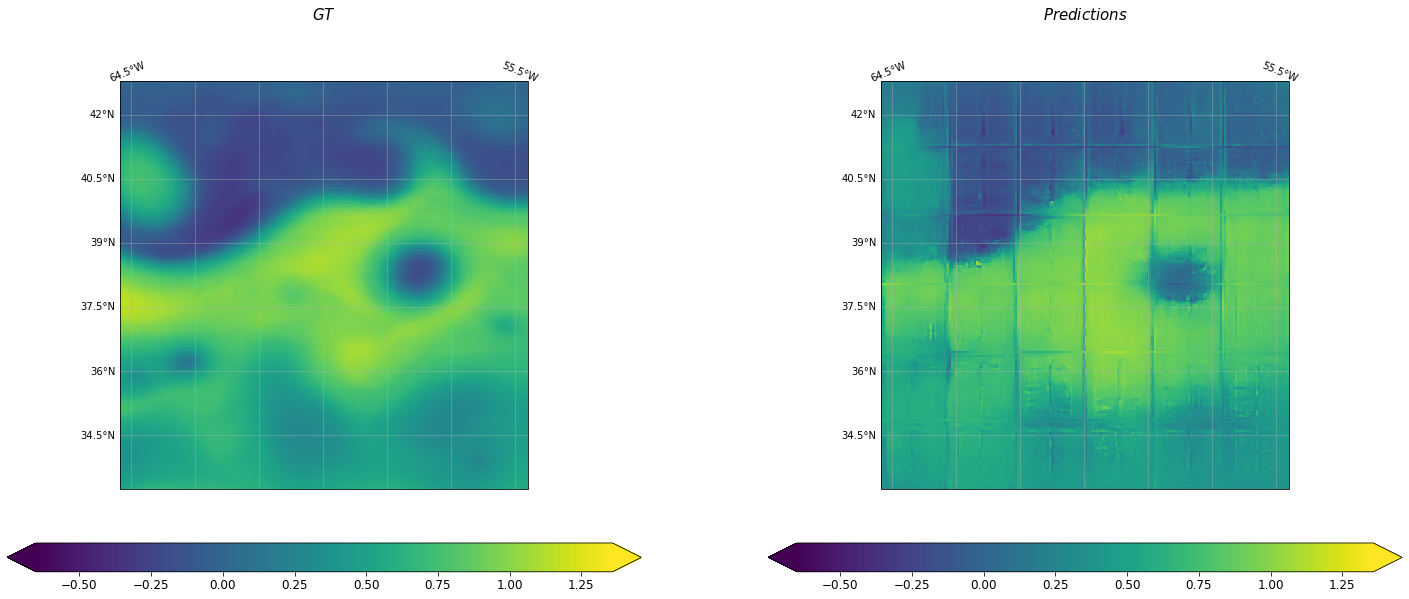

---------- frame 11--------------
Performance : 0.3798403603698084


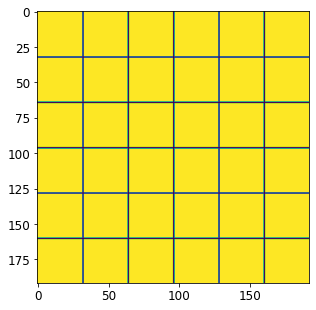

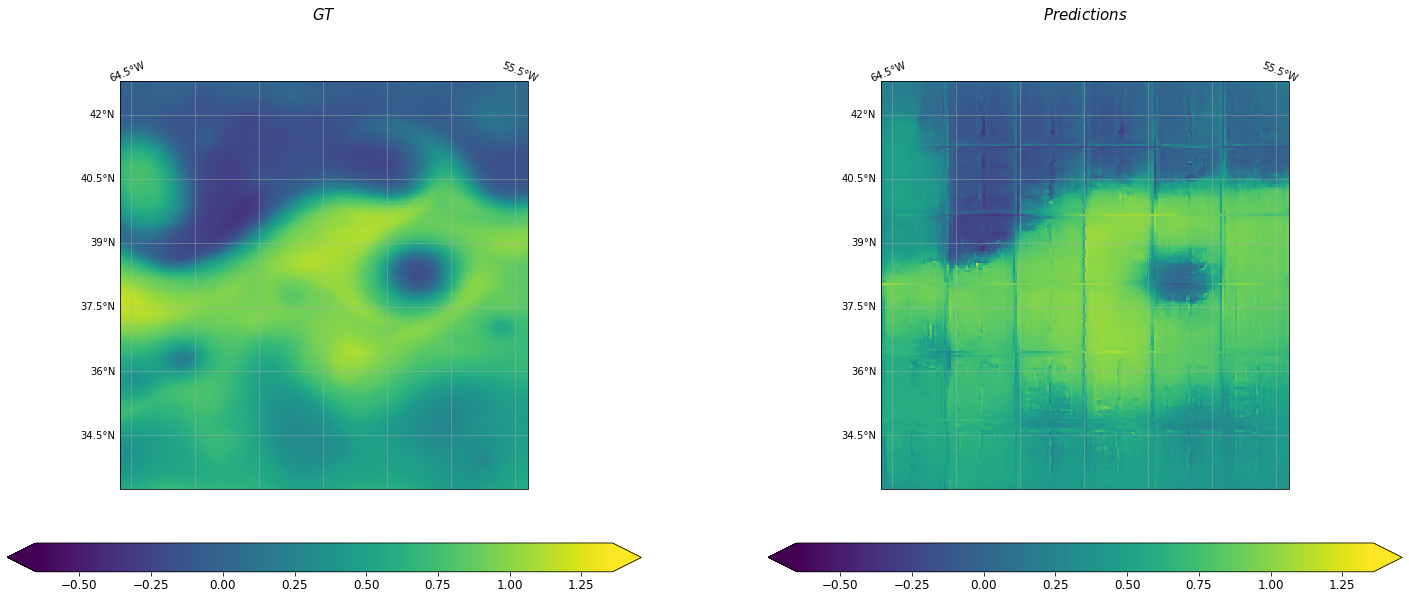

---------- frame 12--------------
Performance : 0.36184565739573415


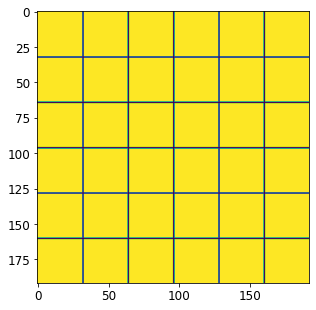

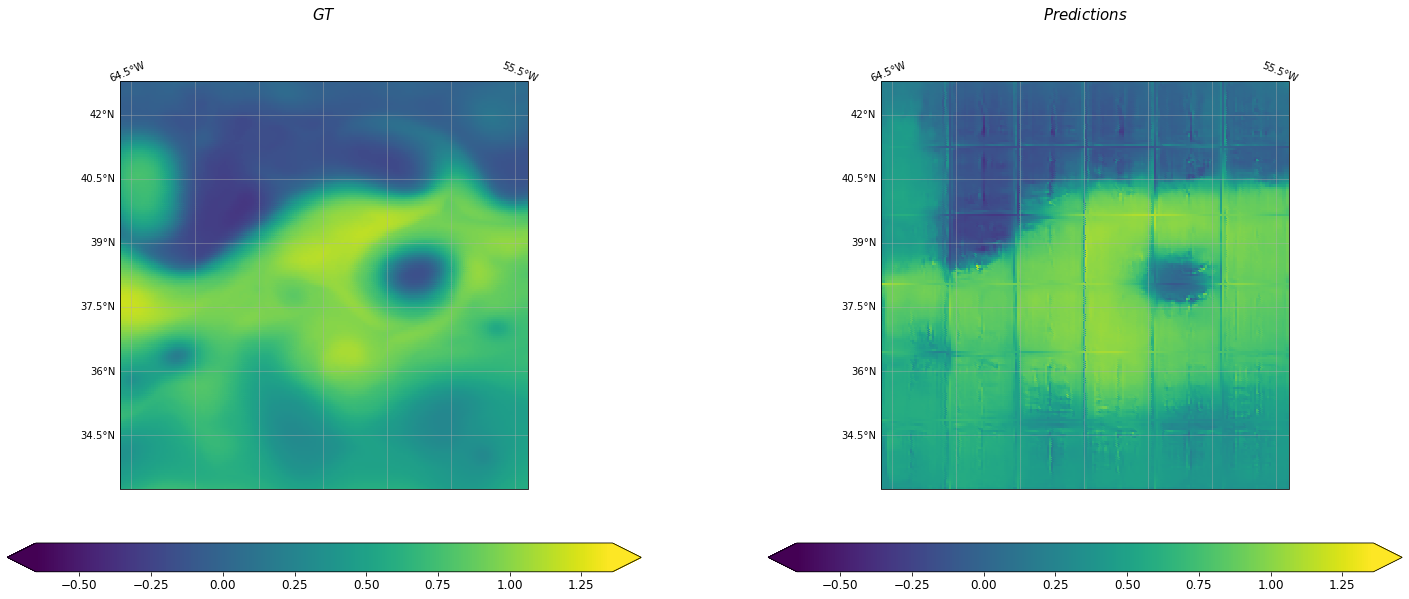

---------- frame 13--------------
Performance : 0.35268487032424006


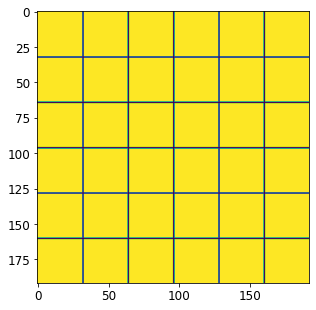

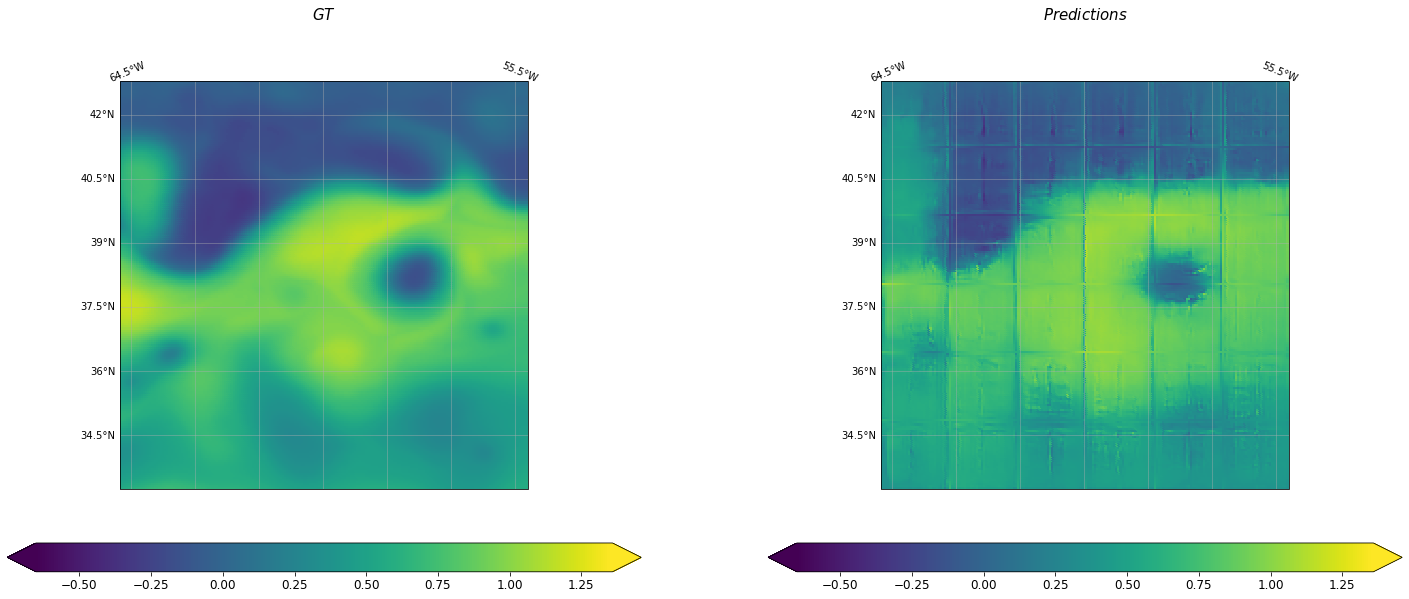

---------- frame 14--------------
Performance : 0.34177465125119405


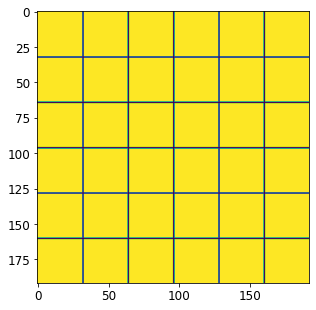

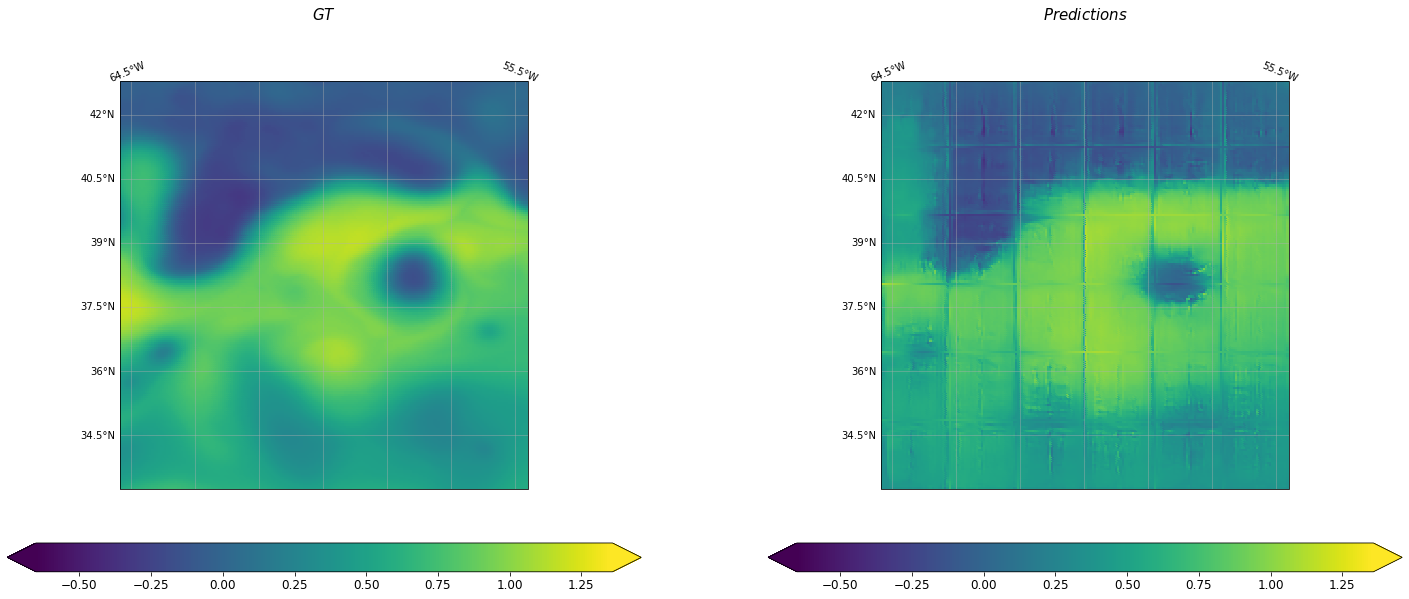

---------- frame 15--------------
Performance : 0.3144431828420967


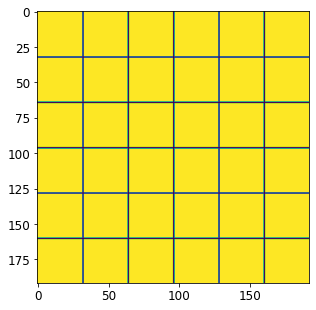

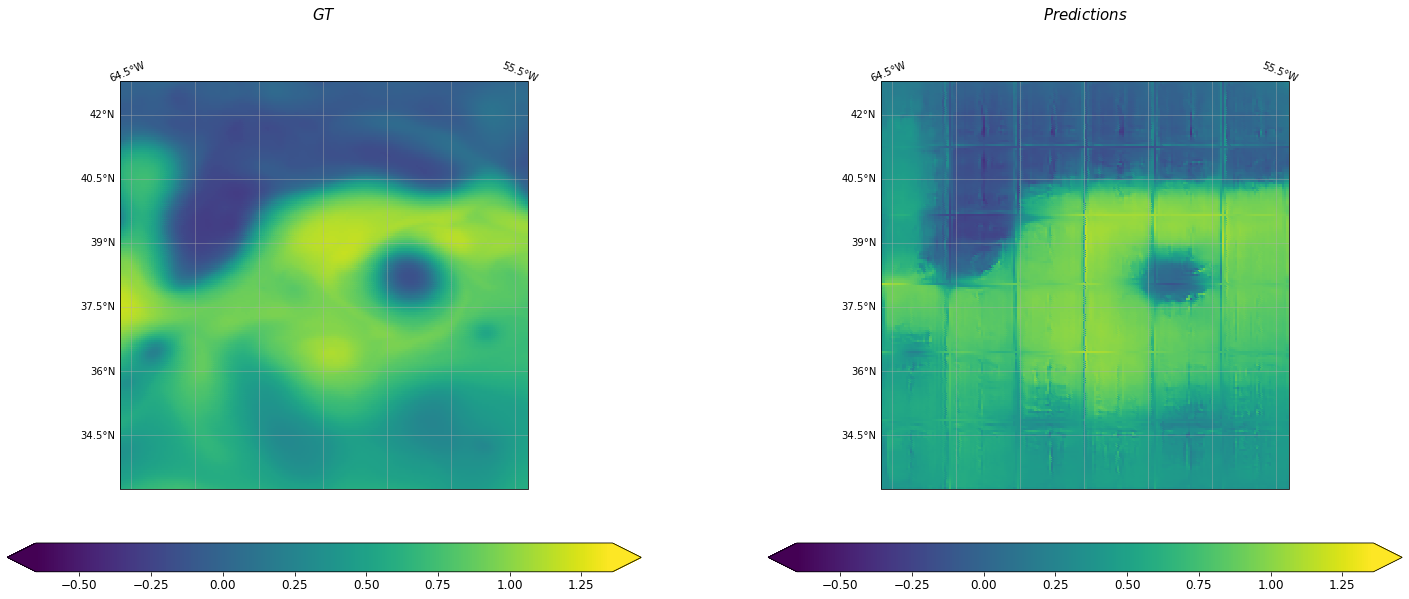

---------- frame 16--------------
Performance : 0.3043119825726714


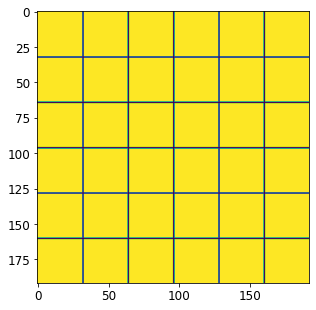

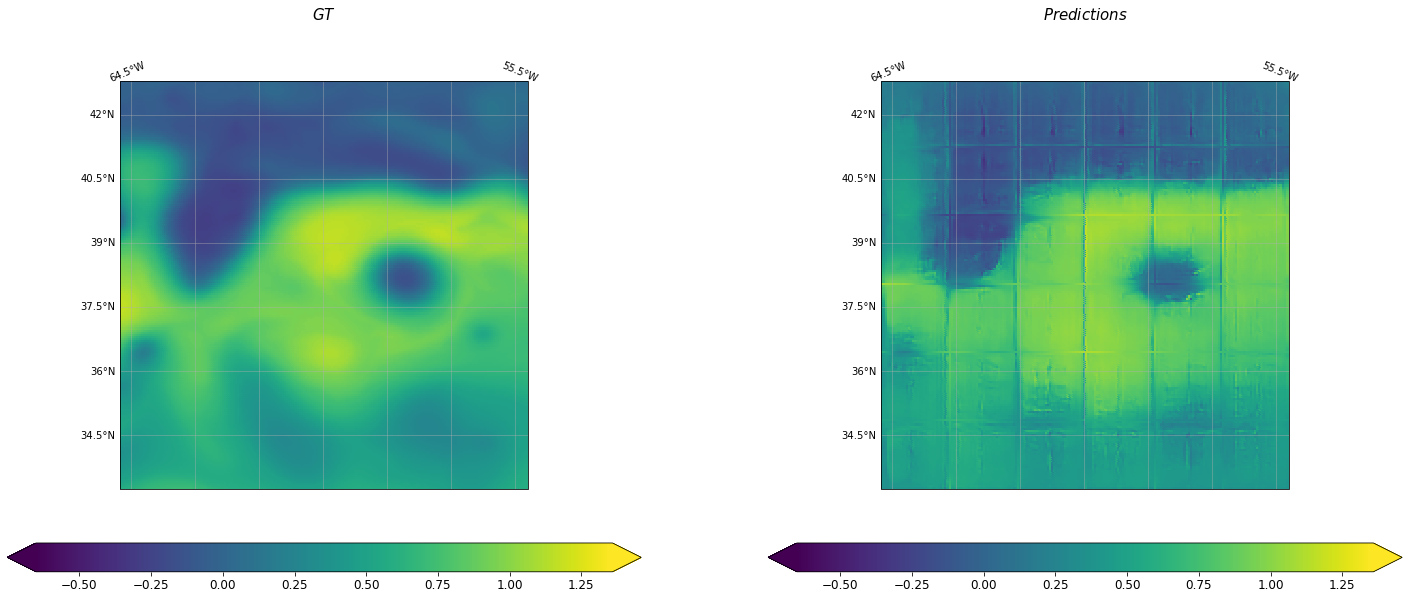

---------- frame 17--------------
Performance : 0.3134852537859242


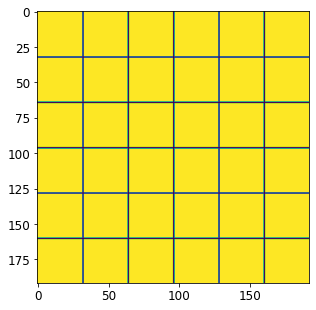

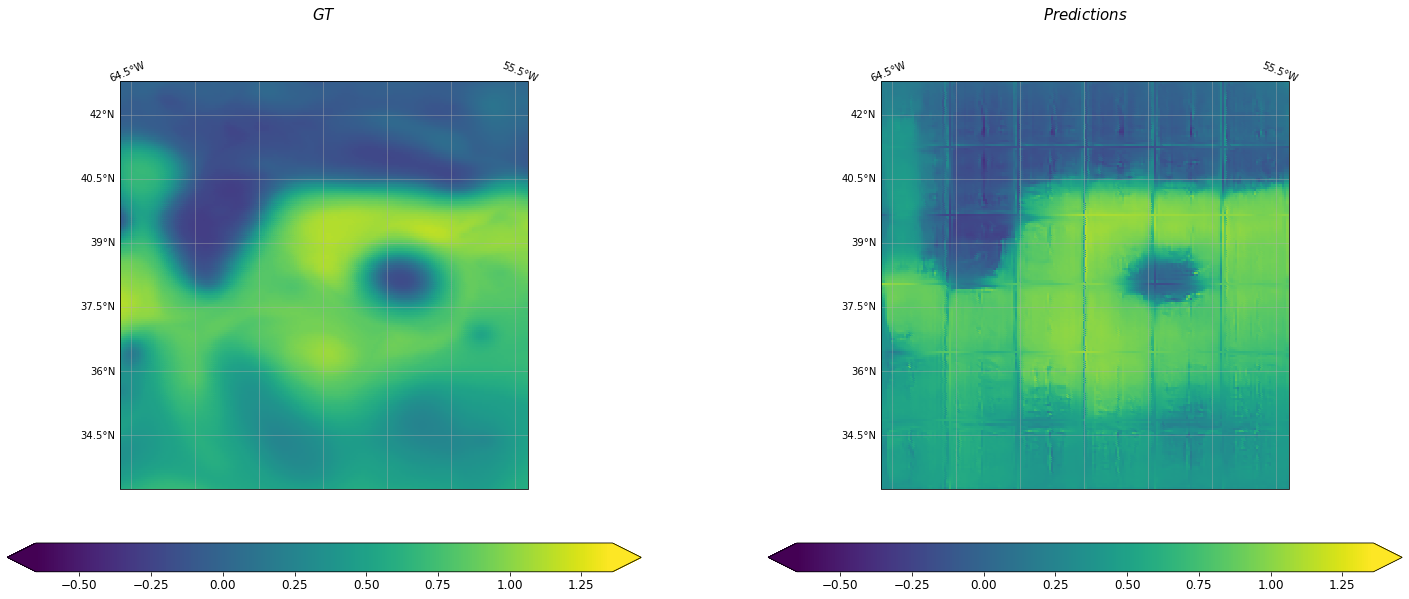

---------- frame 18--------------
Performance : 0.3157952847627712


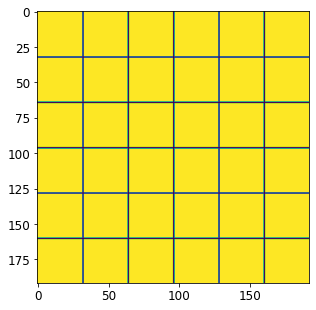

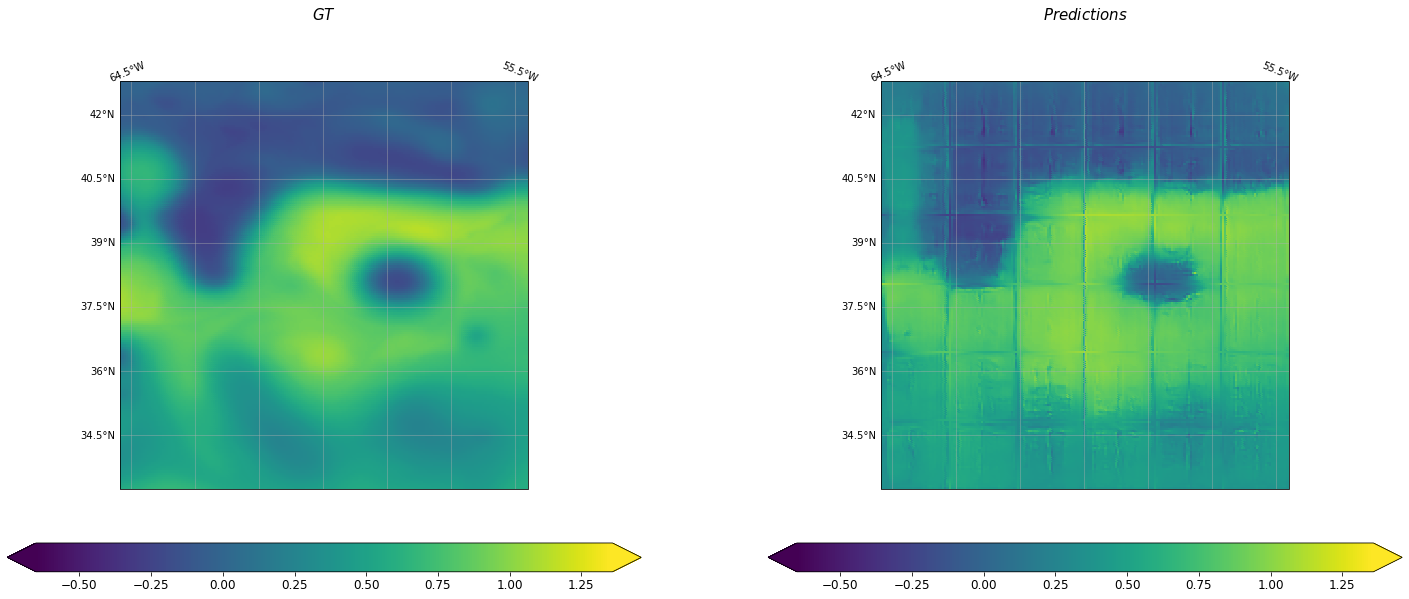

---------- frame 19--------------
Performance : 0.31824455726344014


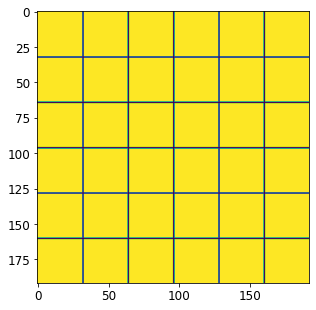

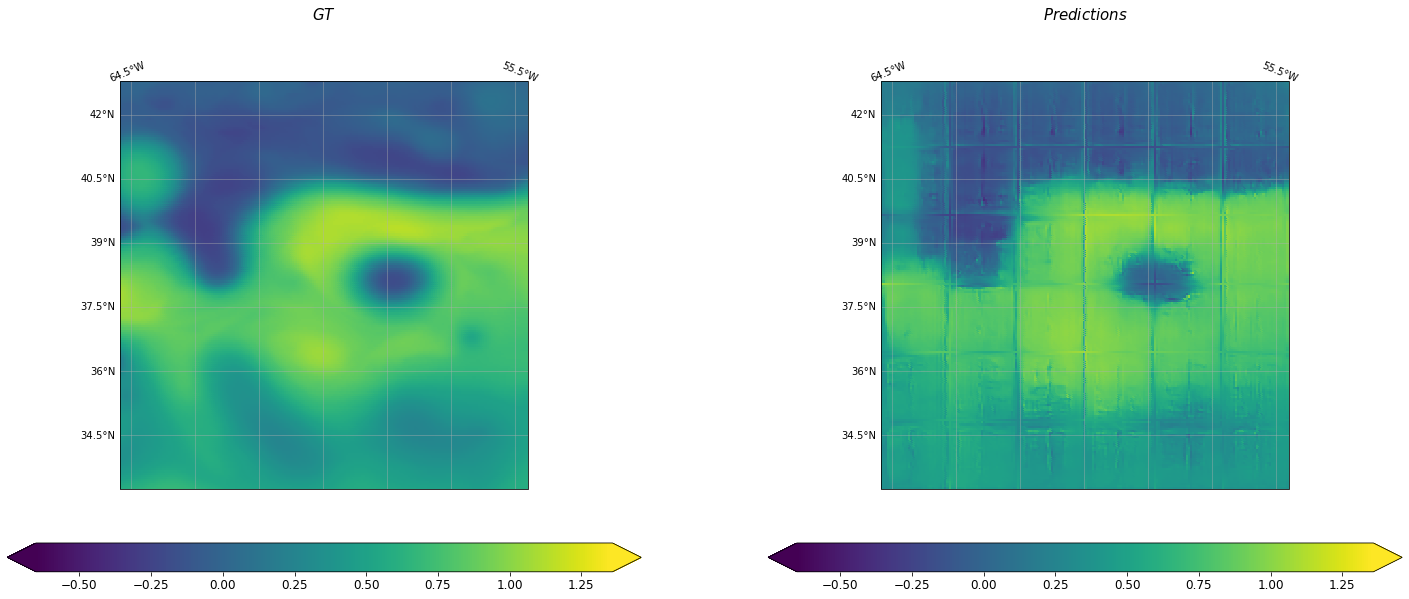

In [36]:
for frame in np.where(nrmse>0.075)[0][:20]:
    print(f'---------- frame {frame}--------------')
    print(f'Performance : {nrmse[frame]}')

    plt.figure(figsize=(5,5))
    plt.imshow(masks[0][frame][0].cpu())

    fig, ax = plt.subplots(1,2,squeeze=False,
                            subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0)))

    plot(ax,0,0,lon,lat,gt[frame], r"$GT$",\
                 extent=extent,cmap='viridis',vmin=minn,vmax=maxx)

    plot(ax,0,1,lon,lat,prediction_ssh[frame], r"$Predictions$",\
                 extent=extent,cmap='viridis',vmin=minn,vmax=maxx)
    plt.show()